In [1]:
%matplotlib notebook

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import os
from matplotlib.patches import Circle
import json

from astropy.time import Time
import datetime
from astroquery.jplhorizons import Horizons
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from photutils.detection import DAOStarFinder
from photutils.psf import (IntegratedGaussianPRF, DAOGroup, IterativelySubtractedPSFPhotometry)
from photutils.background import MMMBackground
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.visualization.wcsaxes import WCSAxes
from astropy import visualization as aviz
from photutils.aperture import (ApertureStats, CircularAnnulus, CircularAperture)
from astropy.stats import SigmaClip
from ccdproc import ImageFileCollection
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.imcce import Skybot

import calviacat as cvc
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.stats import median_abs_deviation
from scipy import odr


This notebook can compile photometry files for a series of lightcurve observations. The photometry must already have been run (e.g danish_phot.py)
- df_fits: metadata on all fits files in series
- df_phot files: source detection file for each fits file
- df_stats files: aperture photometry file for each fits file

In [4]:
# define where the photometry files are located
data_path = os.getcwd()

# define the data night and target

# # night = "20250422"
# # night = "20250424"
# # night = "20250427"
# # night = "20250506"
# # night = "20250509"
# # night = "20250516"
# # night = "20250525"
# # night = "20250619"
# night = "20250623"
# target_name = "Jayewinkler"

# # night = "20250422"
# # night = "20250425" # REFCAT2 fail
# # night = "20250428" # REFCAT2 fail
# # night = "20250501" # Change in observing orientation? "time: 2h20'. at 01:58 change to main mode"
# # night = "20250509"
# # night = "20250514"
# # night = "20250523"
# # night = "20250526"
# # night = "20250601"
# # night = "20250616"
# night = "20250622"
# target_name = "1999 TD2"

# night = "20250422"
# night = "20250423"
# night = "20250502"
# night = "20250503"
# night = "20250505"
# night = "20250614"
night = "20250619"
target_name = "Verstappen"

# # night = "20250425"
# # night = "20250506"
# # night = "20250525"
# night = "20250527"
# target_name = "1993 TT22"

# # night = "20250425" # missing comparison stars?
# night = "20250616"
# target_name = "2000 QN20"

# define telescope and photometry parameteres
site = "W74" # MPC Observatory code
remote_path = "/home/jrobinson" # data path on the remote machine where the reduction was done
local_path = "/Users/jrobinson/telescope_data" # data path on the local machine where this analysis is run
pixel_scale = 0.39 # arcsec/pixel, Danish telescope pixel scale
target_sep_cut = 1e-3 # maximum separation of detection to predicted ephem (degrees)
search_radius = 0.15 # degrees, skybot search radius for secondary targets

target_name_save = "_".join(target_name.split(" "))

In [5]:
# select all fits files (if available)
files = glob.glob("{}/{}/*_wcs.fits".format(data_path,night))
files

['/Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000001_wcs.fits']

In [6]:
fits_fname = "{}/{}/df_fits_{}.csv".format(data_path,night,night)

if os.path.isfile(fits_fname):
    # try load the fits image catalogue created by danish_phot.py
    df_fits = pd.read_csv("{}/{}/df_fits_{}.csv".format(data_path,night,night), index_col=0)
    df_fits = df_fits.sort_values("jd-mid").reset_index(drop = True) # ensure files are in the correct time order

    # update path names so that they can be found on the local machine
    df_fits['file'] = df_fits['file'].str.replace(remote_path,local_path)
else:
    # try make the fits image catalogue from the fits headers
    im_collection=ImageFileCollection(filenames=files)
    df_fits = im_collection.summary.to_pandas()
    df_fits["frame"] = df_fits["file"].str.split("/").str[-1]
    df_fits["night"] = df_fits["file"].str.split("/").str[-2]
    df_fits["jd-mid"] = df_fits["jd"] + ((df_fits["exptime"]/2.0)/(24.0*60.0*60.0))
    # drop any random flat field that snuck through (imagetyp = LIGHT)
    df_fits = df_fits[~df_fits["frame"].str.contains("flat")]
    df_fits = df_fits.reset_index(drop=True)



In [7]:
df_fits

,file,simple,bitpix,naxis,naxis1,naxis2,ctime,usec,jd,date-obs,...,bp_0_2,bp_1_0,bp_1_1,bp_2_0,_ate,comment,history,frame,night,jd-mid
0,/Users/jrobinson/telescope_data/DT_2025/Scienc...,True,-32,2,1998,2020,1750376746,513805,2.460846e+06,2025-06-19T23:45:46.513,...,-3.326856e-07,1.127914e-06,-7.599202e-07,-5.067658e-07,2025-06-24T10:24:19,"Original key: ""EQUINOX"",Original key: ""CROTA2""...",Created with RTS2 version 0.9.4 build on Mar 2...,red_Jayewinkler_000001_wcs.fits,20250619,2.460846e+06
1,/Users/jrobinson/telescope_data/DT_2025/Scienc...,True,-32,2,1998,2020,1750377151,533854,2.460846e+06,2025-06-19T23:52:31.533,...,-1.335078e-06,-1.665270e-06,-4.486988e-07,-8.961671e-07,2025-06-24T10:23:09,"Original key: ""EQUINOX"",Original key: ""CROTA2""...",Created with RTS2 version 0.9.4 build on Mar 2...,red_Jayewinkler_000002_wcs.fits,20250619,2.460846e+06
2,/Users/jrobinson/telescope_data/DT_2025/Scienc...,True,-32,2,1998,2020,1750377636,797754,2.460847e+06,2025-06-20T00:00:36.797,...,-2.932769e-06,-5.410041e-07,8.406831e-10,-7.526858e-07,2025-06-24T10:22:29,"Original key: ""EQUINOX"",Original key: ""CROTA2""...",Created with RTS2 version 0.9.4 build on Mar 2...,red_Jayewinkler_000004_wcs.fits,20250619,2.460847e+06
3,/Users/jrobinson/telescope_data/DT_2025/Scienc...,True,-32,2,1998,2020,1750377898,817831,2.460847e+06,2025-06-20T00:04:58.817,...,-1.456473e-06,1.401830e-06,-5.812897e-07,-7.498321e-07,2025-06-24T10:22:16,"Original key: ""EQUINOX"",Original key: ""CROTA2""...",Created with RTS2 version 0.9.4 build on Mar 2...,red_Jayewinkler_000005_wcs.fits,20250619,2.460847e+06
4,/Users/jrobinson/telescope_data/DT_2025/Scienc...,True,-32,2,1998,2020,1750378048,97826,2.460847e+06,2025-06-20T00:07:28.097,...,-9.687909e-07,1.427988e-06,-5.959046e-07,-1.049099e-06,2025-06-24T10:21:56,"Original key: ""EQUINOX"",Original key: ""CROTA2""...",Created with RTS2 version 0.9.4 build on Mar 2...,red_Jayewinkler_000007_wcs.fits,20250619,2.460847e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,/Users/jrobinson/telescope_data/DT_2025/Scienc...,True,-32,2,1998,2020,1750415298,545782,2.460847e+06,2025-06-20T10:28:18.545,...,3.744207e-07,-1.064989e-06,2.974467e-06,6.535537e-07,2025-06-24T10:23:20,"Original key: ""EQUINOX"",Original key: ""CROTA2""...",Created with RTS2 version 0.9.4 build on Mar 2...,red_Verstappen_R_000054_wcs.fits,20250619,2.460847e+06
71,/Users/jrobinson/telescope_data/DT_2025/Scienc...,True,-32,2,1998,2020,1750415557,893788,2.460847e+06,2025-06-20T10:32:37.893,...,-9.999257e-07,-1.484466e-06,6.934898e-07,-4.766674e-07,2025-06-24T10:23:14,"Original key: ""EQUINOX"",Original key: ""CROTA2""...",Created with RTS2 version 0.9.4 build on Mar 2...,red_Verstappen_R_000056_wcs.fits,20250619,2.460847e+06
72,/Users/jrobinson/telescope_data/DT_2025/Scienc...,True,-32,2,1998,2020,1750415687,24475,2.460847e+06,2025-06-20T10:34:47.024,...,-7.090453e-07,3.609500e-07,1.668364e-06,2.971411e-07,2025-06-24T10:22:11,"Original key: ""EQUINOX"",Original key: ""CROTA2""...",Created with RTS2 version 0.9.4 build on Mar 2...,red_Verstappen_R_000057_wcs.fits,20250619,2.460847e+06
73,/Users/jrobinson/telescope_data/DT_2025/Scienc...,True,-32,2,1998,2020,1750415816,258257,2.460847e+06,2025-06-20T10:36:56.258,...,-7.703117e-07,-1.243070e-06,1.133983e-06,-2.533911e-07,2025-06-24T10:21:49,"Original key: ""EQUINOX"",Original key: ""CROTA2""...",Created with RTS2 version 0.9.4 build on Mar 2...,red_Verstappen_R_000058_wcs.fits,20250619,2.460847e+06


In [8]:
list(df_fits.columns)

['file',
 'simple',
 'bitpix',
 'naxis',
 'naxis1',
 'naxis2',
 'ctime',
 'usec',
 'jd',
 'date-obs',
 'object',
 'exposure',
 'exptime',
 'instrume',
 'telescop',
 'origin',
 'foc_name',
 'utstart',
 '_quinox',
 'ccd_type',
 'ccd_ser',
 'scriprep',
 'script',
 'scr_comm',
 'comm_num',
 'binning',
 'binx',
 'biny',
 'ccd_temp',
 'data_channels',
 'chan',
 'chan1',
 'chan2',
 'gain1',
 'gain2',
 'cdsg',
 'secppix',
 'ccdpsiz',
 'imagetyp',
 'shutter',
 'filta',
 'filtb',
 'mnt_name',
 'latitude',
 'longitud',
 'altitude',
 'orira',
 'oridec',
 'offsra',
 'offsdec',
 'objra',
 'objdec',
 'tarra',
 'tardec',
 'corr_ra',
 'corr_dec',
 'mo_rts2ra',
 'mo_rts2dec',
 'telra',
 'teldec',
 'jd_helio',
 'tel_alt',
 'tel_az',
 'parktime',
 'airmass',
 'ha',
 'lst',
 'move_num',
 'corr_img',
 'mnt_rota',
 'mnt_flip',
 'atsp1en',
 'atsp2en',
 'atsp1ra',
 'atsp1dec',
 'atsp2ts',
 'atsp2pa',
 'aguider_offsra',
 'aguider_offsdec',
 'aguider_stop',
 'agon',
 'agobjra',
 'agobjdec',
 'telstat',
 'pressur

In [9]:
### TODO: NEED TO ADD COSMIC RAY SUBTRACTION TO danish_phot.py!

In [10]:
# select all the PSF photometry files
phot_files = glob.glob("{}/{}/df_phot*csv".format(data_path,night))
phot_files = list(np.sort(np.array(phot_files)))
phot_files = [x for x in phot_files if "flat" not in x] # drop any flat fields that may have snuck through

In [11]:
phot_files

['/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000001_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000002_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000004_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000005_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000007_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000008_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000009_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000010_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000011_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000013_wcs.csv',


In [12]:
# create columns to store the number of detections in the PSF ("phot") and aperture ("stats") photometry files
df_fits["len_phot"] = np.nan
df_fits["len_stats"] = np.nan

In [13]:
# psf fitting was used in danish_phot.py to get source positions and seeing for each frame
# load the PSF fits for each frame into one large catalogue of detections for the whole observing block
df_phot = pd.DataFrame()
fwhm = []
jd_fwhm = []
error_list = []

for f in phot_files:
    
    print(f)
        
    if os.path.isfile(f):
        print("load {}".format(f))
        df = pd.read_csv(f, index_col = 0)
        
    else:
    
        print("error!")
        error_list.append(f)
        
#     # drop weird fits
#     df = df[df["fwhmpix"]!=4.0]
# #     df = df[(df["file"]==f) & (df["fwhmpix"]>0) & (~pd.isnull(df["fwhmpix"]))]
#     df = df[(df["fwhmpix"]>0) & (~pd.isnull(df["fwhmpix"]))]
        
    # add the fits file time
    df["jd-mid"] = np.unique(df_fits[df_fits["file"]==f.replace("df_phot_","").replace(".csv",".fits")]["jd-mid"])[0]
    df_fits.loc[df_fits["file"]==f.replace("df_phot_","").replace(".csv",".fits"),"len_phot"] = len(df)
    df_phot = pd.concat([df_phot,df]).reset_index(drop=True)

    indiv_fwhm = df_phot['fwhmpix']
    fwhm.append((np.nanmedian(indiv_fwhm))) #get average fwhm for each image
    jd_fwhm.append(df.iloc[0]["jd-mid"])
    
# define arrays for the median FWHM as a function of frame time (JD)
fwhm = np.array(fwhm)
jd_fwhm = np.array(jd_fwhm)

# update file paths to local machine
df_phot['file'] = df_phot['file'].str.replace(remote_path,local_path)

/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000001_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000001_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000002_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000002_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000004_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000004_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000005_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000005_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000007_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000007_wcs.csv
/Users/jrobinso

/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Verstappen_R_000025_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Verstappen_R_000025_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Verstappen_R_000026_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Verstappen_R_000026_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Verstappen_R_000028_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Verstappen_R_000028_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Verstappen_R_000031_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Verstappen_R_000031_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Verstappen_R_000032_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Verstappen_R_000032_wcs.csv
/User

In [14]:
error_list

[]

In [15]:
len(df.columns)

23

In [16]:
df_phot.columns

Index(['x_0', 'x_fit', 'y_0', 'y_fit', 'flux_0', 'flux_fit', 'sigma_0',
       'sigma_fit', 'id', 'group_id', 'flux_unc', 'x_0_unc', 'y_0_unc',
       'sigma_unc', 'iter_detected', 'fwhmarcsec', 'fwhmpix', 'file', 'ra_0',
       'dec_0', 'ra_fit', 'dec_fit', 'jd-mid'],
      dtype='object')

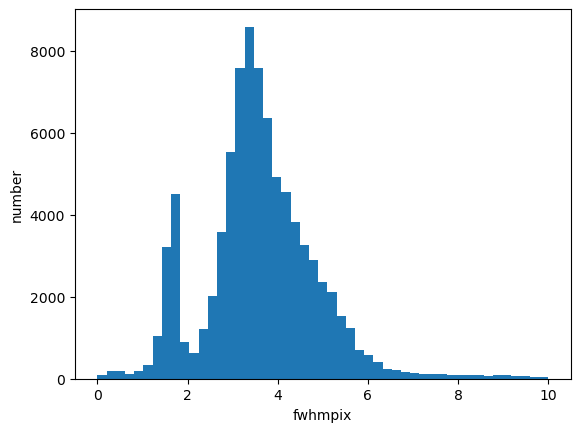

In [17]:
# Plot the distribution of FWHM across all frames
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

ax1.hist(df_phot["fwhmpix"],bins = np.linspace(0,10))

ax1.set_xlabel("fwhmpix")
ax1.set_ylabel("number")

plt.show()

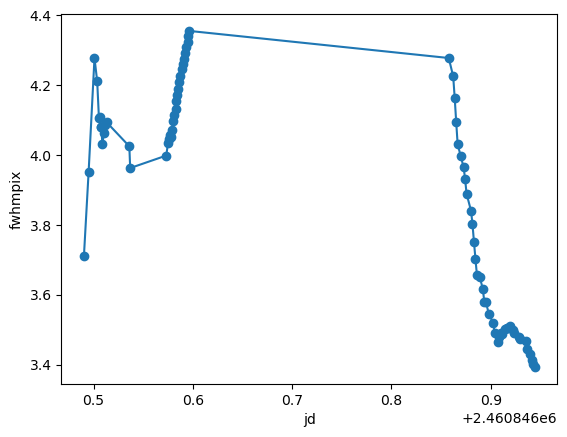

In [18]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

ax1.plot(jd_fwhm, fwhm)
ax1.scatter(jd_fwhm, fwhm)

ax1.set_xlabel("jd")
ax1.set_ylabel("fwhmpix")

plt.show()

/Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000001_wcs.fits
2762


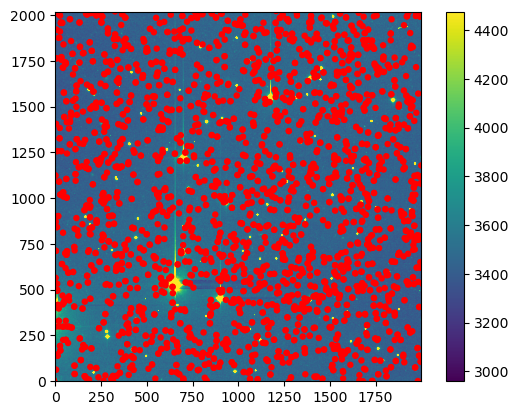

In [19]:
# plot the sources on the frames
# plot the first fits file that we have downloaded
for fi in df_phot["file"]:
    if os.path.isfile(fi):
        f = fi
        break
    else:
        f = None
                
if f:
    
    print(f)
    hdu = fits.open(f)
    img = hdu[0].data
    hdr = hdu[0].header

    fig = plt.figure()
    gs = gridspec.GridSpec(1, 1)
    ax1 = plt.subplot(gs[0,0])

    plot_img = img

    # plot the image
    norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
    s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
    c1 = plt.colorbar(s1)

    # plot all detected sources in the frame
    df_plot = df_phot[(df_phot["file"]==f)]
    print(len(df_plot))

    # ax1.scatter(df_plot["x_fit"],df_plot["y_fit"],edgecolor="r", facecolor = "none", s = 100)
    # ax1.scatter(df_plot.iloc[567]["x_fit"],df_plot.iloc[567]["y_fit"],edgecolor="r", facecolor = "none", s = 100)

    # plot the detected sources as apertures with fwhm size
    aperture = CircularAperture(positions = np.array(df_plot[["x_fit","y_fit"]]),
                                 r = fwhm[0])
    aperture.plot(color="r")

    # plot the annuli used for background estimation
    annuli = CircularAnnulus(positions = np.array(df_plot[["x_fit","y_fit"]]), 
                             r_in=fwhm[0]+5, r_out=fwhm[0]+10)
    annuli.plot(color="r")


    plt.show()

In [20]:
# select the files containing the aperture photometry results created by danish_phot.py
stat_files = glob.glob("{}/{}/df_stats*csv".format(data_path,night))
stat_files = list(np.sort(np.array(stat_files)))
stat_files = [x for x in stat_files if "flat" not in x] # drop random flat fields
stat_files

['/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Jayewinkler_000001_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Jayewinkler_000002_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Jayewinkler_000004_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Jayewinkler_000005_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Jayewinkler_000007_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Jayewinkler_000008_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Jayewinkler_000009_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Jayewinkler_000010_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Jayewinkler_000011_wcs.csv',
 '/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Jayewinkler_000013_

In [21]:
# compile the aperture photometry results for each frame into a catalogue of all detections for the observing block

df_stats = pd.DataFrame()
error_list = []

for i,f in enumerate(phot_files):
    
    print(f)
    
    fname_stats = "{}/df_stats_{}".format("/".join(f.split("/")[:-1]),f.split("/")[-1].split("df_phot_")[-1])
    
    if os.path.isfile(fname_stats):
        print("load {}".format(fname_stats))
        df = pd.read_csv(fname_stats, index_col = 0)
     
    else:
        
        print("error!")
        error_list.append(f)
        
#     # keep only positive flux detections
#     df = df[(df["flux_fit_aper"]>0)]

    df_fits.loc[df_fits["file"]==f.replace("df_phot_","").replace(".csv",".fits"),"len_stats"] = len(df)

    df_stats = pd.concat([df_stats,df]).reset_index(drop=True)
       
# combine the PSF and aperture dataframes into one combined catalogue
df_phot = pd.concat([df_phot,df_stats],axis=1)

/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000001_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Jayewinkler_000001_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000002_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Jayewinkler_000002_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000004_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Jayewinkler_000004_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000005_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Jayewinkler_000005_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Jayewinkler_000007_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Jayewinkler_000007_wcs.csv
/Users/jro

/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Verstappen_R_000035_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Verstappen_R_000035_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Verstappen_R_000036_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Verstappen_R_000036_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Verstappen_R_000037_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Verstappen_R_000037_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Verstappen_R_000039_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Verstappen_R_000039_wcs.csv
/Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_phot_red_Verstappen_R_000040_wcs.csv
load /Users/jrobinson/telescope_data/DT_2025/Science/20250619/df_stats_red_Verstappen_R_000040_wcs.csv


In [22]:
error_list

[]

In [23]:
# check for any problem files that do not have measurements for all detected sources
df_fits[df_fits["len_phot"]!=df_fits["len_stats"]]

,file,simple,bitpix,naxis,naxis1,naxis2,ctime,usec,jd,date-obs,...,bp_1_1,bp_2_0,_ate,comment,history,frame,night,jd-mid,len_phot,len_stats


In [24]:
df_phot.columns

Index(['x_0', 'x_fit', 'y_0', 'y_fit', 'flux_0', 'flux_fit', 'sigma_0',
       'sigma_fit', 'id', 'group_id', 'flux_unc', 'x_0_unc', 'y_0_unc',
       'sigma_unc', 'iter_detected', 'fwhmarcsec', 'fwhmpix', 'file', 'ra_0',
       'dec_0', 'ra_fit', 'dec_fit', 'jd-mid', 'id_aper', 'xcentroid',
       'ycentroid', 'sum', 'sum_err', 'sum_aper_area', 'center_aper_area',
       'min', 'max', 'mean', 'median', 'mode', 'std', 'mad_std', 'var',
       'biweight_location', 'biweight_midvariance', 'fwhm', 'semimajor_sigma',
       'semiminor_sigma', 'orientation', 'eccentricity', 'bkgsub',
       'flux_fit_aper', 'ra_centroid', 'dec_centroid'],
      dtype='object')

In [25]:
# calculate instrumental (i.e. uncalibrated) magnitude and uncertainty for each detection
df_phot["m_inst"] = -2.5*np.log10(df_phot['flux_fit_aper'])
df_phot["m_inst_err"] = np.sqrt((np.array(df_phot['sum']) + np.array(df_phot['sum_err'])))/np.array(df_phot['bkgsub']) * 1.0857

/Users/jrobinson/miniconda3/envs/img_red2/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_3860/2613283131.py:3: RuntimeWarning: invalid value encountered in sqrt
  df_phot["m_inst_err"] = np.sqrt((np.array(df_phot['sum']) + np.array(df_phot['sum_err'])))/np.array(df_phot['bkgsub']) * 1.0857


In [26]:
df_phot[["flux_fit_aper","m_inst","m_inst_err"]].sort_values("m_inst_err")

,flux_fit_aper,m_inst,m_inst_err
83612,-0.383974,NaN,-1588.007324
69286,-0.629359,NaN,-984.423959
59132,-2.388007,NaN,-257.050551
15927,-4.213734,NaN,-70.559786
34786,-16.735558,NaN,-32.070275
...,...,...,...
97657,NaN,NaN,NaN
97665,NaN,NaN,NaN
97678,NaN,NaN,NaN
98141,NaN,NaN,NaN


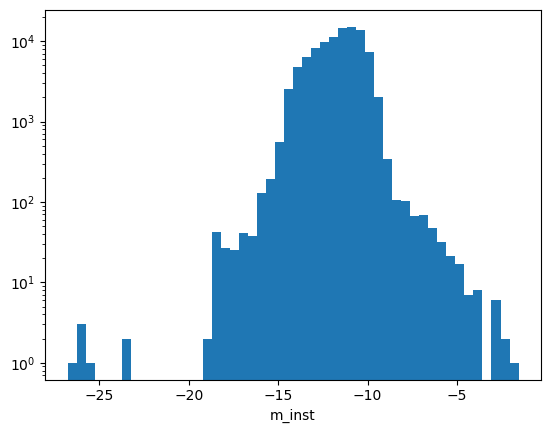

In [27]:
# Plot the distribution of instrumental magnitudes
x_plot = "m_inst"
df_plot = df_phot
bins = 50

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

ax1.hist(df_plot[x_plot], bins = bins)

ax1.set_xlabel(x_plot)
ax1.set_yscale("log")

plt.show()

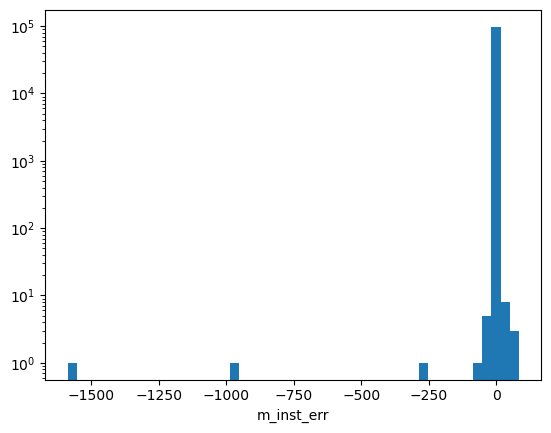

In [28]:
# distribution of magnitude uncertainties
x_plot = "m_inst_err"
df_plot = df_phot
bins = 50

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

ax1.hist(df_plot[x_plot], bins = bins)

ax1.set_xlabel(x_plot)
ax1.set_yscale("log")

plt.show()

# conesearch field for targets

In [29]:
# Some observations may have other moving targets in the same field of view
# We search for known object near target ephemerides

In [30]:
# query Horizons for the target position during the observing block
epochs = {"start":"{}".format(Time(np.amin(df_fits["jd-mid"]-0.005), format="jd").iso),
         "stop":"{}".format(Time(np.amax(df_fits["jd-mid"])+0.005, format="jd").iso), # make the query cover end step
         "step":"5min"}
epochs

{'start': '2025-06-19 23:38:56.500',
 'stop': '2025-06-20 10:47:07.000',
 'step': '5min'}

In [31]:
obj = Horizons(id=target_name, location = site, epochs = epochs)
eph = obj.ephemerides()
df_eph = eph.to_pandas()
eph_c = SkyCoord(df_eph["RA"], df_eph["DEC"],  unit=(u.deg, u.deg))

In [32]:
df_eph

,targetname,datetime_str,datetime_jd,H,G,solar_presence,flags,RA,DEC,RA_app,...,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
0,12630 Verstappen (3033 T-1),2025-Jun-19 23:38:56.500,2.460846e+06,14.75,0.15,,,300.12315,-32.26346,300.53356,...,0.8542,3.000000e-07,0.01,0.03,0.000006,335.9382,-7.205988,13.5567,289.2653,-8.9477
1,12630 Verstappen (3033 T-1),2025-Jun-19 23:43:56.500,2.460846e+06,14.75,0.15,,,300.12268,-32.26372,300.53309,...,0.8541,3.000000e-07,0.01,0.03,0.000006,335.9393,-7.122395,13.5552,289.2657,-8.9478
2,12630 Verstappen (3033 T-1),2025-Jun-19 23:48:56.500,2.460846e+06,14.75,0.15,,,300.12221,-32.26398,300.53262,...,0.8540,3.000000e-07,0.01,0.03,0.000006,335.9405,-7.038802,13.5538,289.2661,-8.9478
3,12630 Verstappen (3033 T-1),2025-Jun-19 23:53:56.500,2.460846e+06,14.75,0.15,,,300.12173,-32.26424,300.53215,...,0.8539,3.000000e-07,0.01,0.03,0.000006,335.9417,-6.955209,13.5524,289.2664,-8.9479
4,12630 Verstappen (3033 T-1),2025-Jun-19 23:58:56.500,2.460846e+06,14.75,0.15,,,300.12126,-32.26450,300.53168,...,0.8538,3.000000e-07,0.01,0.03,0.000006,335.9429,-6.871616,13.5509,289.2668,-8.9480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,12630 Verstappen (3033 T-1),2025-Jun-20 10:23:56.500,2.460847e+06,14.75,0.15,A,m,300.05584,-32.29513,300.46652,...,0.8394,3.000000e-07,0.01,0.03,0.000006,336.0902,3.577914,13.3672,289.3106,-8.9546
130,12630 Verstappen (3033 T-1),2025-Jun-20 10:28:56.500,2.460847e+06,14.75,0.15,A,m,300.05531,-32.29535,300.46599,...,0.8393,3.000000e-07,0.01,0.03,0.000006,336.0914,3.661511,13.3657,289.3110,-8.9547
131,12630 Verstappen (3033 T-1),2025-Jun-20 10:33:56.500,2.460847e+06,14.75,0.15,A,m,300.05478,-32.29557,300.46546,...,0.8392,3.000000e-07,0.01,0.03,0.000006,336.0926,3.745107,13.3642,289.3113,-8.9547
132,12630 Verstappen (3033 T-1),2025-Jun-20 10:38:56.500,2.460847e+06,14.75,0.15,A,m,300.05426,-32.29579,300.46494,...,0.8391,3.000000e-07,0.01,0.03,0.000006,336.0938,3.828704,13.3628,289.3117,-8.9547


In [33]:
# find the median ephemeris position for the block
# NB we might miss some secondary targets if the primary moves significantly during the observing block
ra_med = np.nanmedian(df_eph["RA"])
dec_med = np.nanmedian(df_eph["DEC"])
jd_med = np.nanmedian(df_eph["datetime_jd"])

In [34]:
# Define median ephemeris as SkyCoord
eph_med_c = SkyCoord(ra_med, dec_med,  unit=(u.deg, u.deg))

# cut outlying photometry - the photometry pipeline sometimes produces weird measurements for RA and Dec which would mess up our plots
phot_c = SkyCoord(df_phot["ra_centroid"], df_phot["dec_centroid"],  unit=(u.deg, u.deg))
med_sep = eph_med_c.separation(phot_c).degree
mask_phot = (med_sep < 4.0*search_radius)
print(len(df_phot))
df_phot = df_phot[mask_phot].reset_index(drop=True)
print(len(df_phot))

# cut outlying fits files - the observing block may have had some images off target (e.g. slew error)
fits_c = SkyCoord(ra = df_fits["objra"], dec = df_fits["objdec"], unit=(u.hourangle, u.deg))
med_sep = eph_med_c.separation(fits_c).degree
mask_fits = (med_sep < 4.0*search_radius)
print(len(df_fits))
df_fits = df_fits[mask_fits].reset_index(drop=True)
print(len(df_fits))

98154
65106
75
39


In [35]:
epoch = Time(jd_med, format='jd')
results = Skybot.cone_search(eph_med_c, search_radius*u.deg, epoch)
df_results = results.to_pandas()

In [36]:
df_results

,Number,Name,RA,DEC,Type,V,posunc,centerdist,RA_rate,DEC_rate,...,heliodist,alpha,elong,x,y,z,vx,vy,vz,epoch
0,12630,Verstappen,300.088776,-32.280669,MB>Inner,17.7,0.015,2.171,-17.9986,-10.314,...,2.122549,13.45,150.98,0.393777,-1.808412,-1.039672,0.012180,0.002678,0.001365,2460840.0
1,691004,2014 OP65,299.990942,-32.331902,MB>Outer,21.5,0.042,352.248,-20.4074,-4.110,...,2.968768,9.55,151.06,0.772735,-2.436970,-1.508786,0.009762,0.002268,0.002409,2460840.0
2,<NA>,2022 UQ101,300.085590,-32.385873,MB>Middle,24.6,43.345,379.420,-22.8955,-14.099,...,3.614360,7.85,150.97,1.073164,-2.918622,-1.843693,0.006518,0.003235,-0.000089,2460840.0


save conesearch_20250619_Verstappen.pdf


<function matplotlib.pyplot.show(close=None, block=None)>

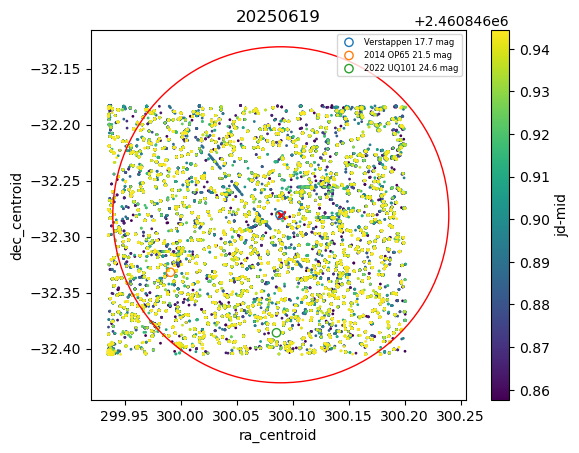

In [37]:
# plot all RA and Dec of detections, coloured by time
# moving objects will appear as lines of detections with increasing time

x_plot = "ra_centroid"
y_plot = "dec_centroid"
c_plot = "jd-mid"
df_plot = df_phot.sort_values(c_plot)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

# plot all detections with colour scale
s1 = ax1.scatter(df_plot[x_plot],df_plot[y_plot],c=df_plot[c_plot],s=1, rasterized = True)
cbar = plt.colorbar(s1)

# plot median of field to search for extra objects
ax1.scatter(ra_med, dec_med,c="r",marker = "x")
# plot the search radius
c = Circle((ra_med, dec_med), search_radius, edgecolor='r', facecolor='none')
ax1.add_patch(c)

# plot detected objects
for i in range(len(df_results)):
    _df = df_results.iloc[i]
    name = _df["Name"]
    V = _df["V"]
    ra = _df["RA"]
    dec = _df["DEC"]
    ax1.scatter(ra, dec,edgecolor="C{}".format(i), facecolor = "none", label = "{} {} mag".format(name,V))

ax1.set_aspect("equal")
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
cbar.set_label(c_plot)
ax1.legend(fontsize=6)

plt.title(night)

# save figure as pdf (vectorised points for higher resolution)
target_name_save = "_".join(target_name.split(" "))
fname = "conesearch_{}_{}.pdf".format(night,target_name_save)
print("save {}".format(fname))
plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")

plt.show

In [38]:
# Continue with the original target
target_name_new = None

# # Or pick a new target from the skybot results?
# target_name_new = "Kagekatu" # 20250505
# target_name_new = "Emilypang" # 20250502, 20250503
# target_name_new = "2002 GP190" # 20250501
# target_name_new = "2006 UW198" # 20250428
# target_name = "2000 AV133" # 20250526
# target_name = "2006 SC12" # 20250601

# rerun eph query for a new target
if target_name_new:
    target_name = target_name_new

    obj = Horizons(id=target_name, location = site, epochs = epochs)
    eph = obj.ephemerides()
    df_eph = eph.to_pandas()
    eph_c = SkyCoord(df_eph["RA"], df_eph["DEC"],  unit=(u.deg, u.deg))
    
target_name_save = "_".join(target_name.split(" "))

# photometric calibration

In [39]:
# First we must identify the source in each frame that corresponds to the target
# We will interpolate the predicted ephemerides to get the exact position at the time of each frame
times = Time(list(df_eph["datetime_jd"]),format="jd")
x = eph_c.ra.value
y = eph_c.dec.value
t = np.array([t.jd for t in times])

In [40]:
# define a linear function
def linear_func(x, m, c):
    return m*x + c

In [41]:
frame_times = np.array(Time(df_fits["jd-mid"], format="jd").jd)

if len(x)>3:
    # interpolate instead of fitting directly
    # a linear fit over multiple nights will not fit so good!
    
    # NB the univariate spline did not always work well
#     f_ra = interpolate.UnivariateSpline(t, x)
#     ra_fit=f_ra(frame_times)
#     f_dec = interpolate.UnivariateSpline(t, y)
#     dec_fit=f_dec(frame_times)
    
    # A simple 1 dimensional interpolation works well (provided eph step size is small enough)
    # fit ra as a function of time
    f_ra = interpolate.interp1d(t,x)
    ra_fit=f_ra(frame_times)
    # fit dec as a function of time
    f_dec = interpolate.interp1d(t,y)
    dec_fit=f_dec(frame_times)

else:
    # when we don't have enough data points just use a simple linear interpolation
    # fit ra as a function of time
    popt_x, pcov_x = curve_fit(linear_func, t, x)
    ra_fit = linear_func(frame_times,*popt_x)
    # fit dec as a function of time
    popt_y, pcov_y = curve_fit(linear_func, t, y)
    dec_fit = linear_func(frame_times,*popt_y)
    
# add the predicted target positions to the catalogue
df_fits["ra_eph"] = ra_fit
df_fits["dec_eph"] = dec_fit

In [42]:
x

array([300.12315, 300.12268, 300.12221, 300.12173, 300.12126, 300.12078,
       300.12031, 300.11983, 300.11935, 300.11887, 300.11839, 300.1179 ,
       300.11742, 300.11693, 300.11645, 300.11596, 300.11547, 300.11498,
       300.11449, 300.114  , 300.11351, 300.11301, 300.11252, 300.11202,
       300.11152, 300.11103, 300.11053, 300.11002, 300.10952, 300.10902,
       300.10852, 300.10801, 300.1075 , 300.107  , 300.10649, 300.10598,
       300.10547, 300.10496, 300.10444, 300.10393, 300.10342, 300.1029 ,
       300.10239, 300.10187, 300.10135, 300.10083, 300.10031, 300.09979,
       300.09927, 300.09874, 300.09822, 300.0977 , 300.09717, 300.09664,
       300.09612, 300.09559, 300.09506, 300.09453, 300.094  , 300.09347,
       300.09294, 300.09241, 300.09188, 300.09134, 300.09081, 300.09027,
       300.08974, 300.0892 , 300.08867, 300.08813, 300.08759, 300.08706,
       300.08652, 300.08598, 300.08544, 300.0849 , 300.08436, 300.08382,
       300.08328, 300.08274, 300.0822 , 300.08166, 

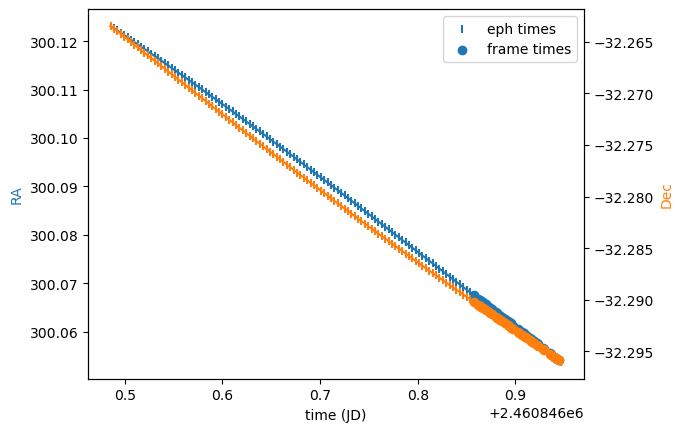

In [43]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

ax1.plot(t,f_ra(t),c="C0")
ax1.scatter(t,x,marker = "|", c = "C0", label="eph times")
ax1.scatter(frame_times,ra_fit,c="C0", label="frame times")
ax1.set_ylabel("RA")
ax1.yaxis.label.set_color('C0')

ax2 = ax1.twinx()
ax2.plot(t,f_dec(t),c="C1")
ax2.scatter(t,y,marker = "|", c = "C1", label="eph times")
ax2.scatter(frame_times,dec_fit,c="C1", label="frame times")
ax2.set_ylabel("Dec")
ax2.yaxis.label.set_color('C1')

ax1.legend()
ax1.set_xlabel("time (JD)")

plt.show()

In [44]:
# We also interpolate values for phase angle, heliocentric dist and geocentric distance
# These will be needed for phase corrections
df_eph = df_eph.rename({"alpha":"alpha(deg)","r":"r(AU)","delta":"delta(AU)"}, axis = 1) # rename to avoid name conflicts later
for x_col in ["alpha(deg)","r(AU)","delta(AU)"]:
    x = np.array(df_eph[x_col])
    f_t = interpolate.interp1d(t,x)
    x_fit=f_t(frame_times)
    df_fits[x_col] = x_fit

In [45]:
# drop nans in photometry files
df_phot = df_phot.dropna(how = "any").reset_index(drop=True)

# drop weird detections
df_phot = df_phot[df_phot["fwhmpix"]!=4.0]
#     df_phot = df_phot[(df_phot["file"]==f) & (df_phot["fwhmpix"]>0) & (~pd.isnull(df_phot["fwhmpix"]))]
df_phot = df_phot[(df_phot["fwhmpix"]>0) & (~pd.isnull(df_phot["fwhmpix"]))]

# keep only positive flux detections
df_phot = df_phot[(df_phot["flux_fit_aper"]>0)]

# # drop high uncertainty mag errors
# df_phot = df_phot[df_phot["m_inst_err"]<1.0].reset_index(drop=True)

In [46]:
# check coverage and choose reference catalogue

# ATLAS has better sky coverage, but the query runs slower
# PS1 is limited to northern sky, but query is faster
# Also consider the filters that are available in each catalogue

# PS1, dec > -30 deg, grizy
# Skymapper, dec < 15 deg, uvgriz
# ATLAS RC2, dec , grizJHK

In [47]:
# You will probably need credentials to query MAST
# See the calvicat README: https://github.com/mkelley/calviacat

# I have stored my credentials in a file
# mast_credentials = {"mast_user":"...",
#                    "mast_pword":"...!"}

# with open('mast_credentials.json', 'w') as f:
#     json.dump(mast_credentials, f)

# load credentials from file
mast_credentials= json.load( open('mast_credentials.json') )
mast_credentials

{'mast_user': '489850414', 'mast_pword': 'Surfingbird!'}

In [48]:
# Set your own user and password here
mast_user = mast_credentials["mast_user"]
mast_pword = mast_credentials["mast_pword"]

# # PS1 columns
# columns = ['objname','objid','ramean','decmean','rameanerr','decmeanerr',
#            'rmeanpsfmag','rmeanpsfmagerr','rmeanapmag','rmeanapmagerr',
#            'gmeanpsfmag','gmeanpsfmagerr',
#           'rastack','decstack','rastackerr','decstackerr',
#           'imeanpsfmag','imeanpsfmagerr','imeankronmag','imeankronmagerr']

# ATLAS columns to query
columns = ['objid','RA','Dec','g','dg','gchi','gcontrib','r','dr',
    'rchi','rcontrib','i','di','ichi','icontrib','z','dz',
    'zchi','zcontrib','nstat','J','dJ','H','dH','K','dK',]

# define which columns we will use for calibration
mag_obs = "r"
mag_obs_err = "dr"
mag_ref = "g"
mag_ref_err = "dg"

In [49]:
# perform the photometric catalogue cross match

df_phot_cal = pd.DataFrame()
error_list = []

for i in range(len(df_fits)):
    
    _df_fits = df_fits.iloc[i]
    fits_file = _df_fits["file"]
    
    # load all photometry
    print("{}/{}: {}".format(i+1,len(df_fits),fits_file))

    # get all detections in a given frame
    df = df_phot[(df_phot["file"]==fits_file) & (df_phot["jd-mid"]==_df_fits["jd-mid"])].reset_index(drop=True)
    print(len(df))
    # get SkyCoords for each detection in frame
    c = SkyCoord(ra = df["ra_centroid"], dec = df["dec_centroid"], unit=(u.deg, u.deg))

    # calviacat source match with ATLAS refcat
    # limit query to not break MAST
    # use the median coords to approximate centre of frame
    eph_fits = SkyCoord(ra = np.nanmedian(df["ra_centroid"]), dec = np.nanmedian(df["dec_centroid"]), unit=(u.deg, u.deg))
    print(eph_fits.to_string("hmsdms", alwayssign=True),eph_fits)   
    # Use only detections within a certain radius of frame centre
    sep = eph_fits.separation(c).degree
    sep_mask = sep<(0.5)
    lco = c[sep_mask]

    rc2 = cvc.RefCat2("cat.db", wsid=mast_user, password=mast_pword)
    
    # download catalog if not already cached?
    if len(rc2.search(lco)[0]) < 500:
        rc2.fetch_field(lco)
    # crossmatch LCO photometry table with catalog
    try:
        objids, distances = rc2.xmatch(c)
    except:
        print("catalogue error?")
        error_list.append(fits_file)
        continue

    # lookup the catalogue for each matched object
    data = rc2.lookup(objids.data[~objids.mask],",".join(columns))
    tab = [list(d) for d in data]   
    df_RC2 = pd.DataFrame(data = tab, columns = columns)
    
    # assign ids to all detections (unmatched values = 999999)
    df["objid"] = np.array(objids.filled())
    df["distances"] = np.array(distances.filled())

    # find the target  as the nearest source to the predicted ephemerides
    _eph_c = SkyCoord(ra = _df_fits["ra_eph"], dec = _df_fits["dec_eph"], unit = (u.deg,u.deg))
    print(_eph_c)
    sep = _eph_c.separation(c).degree
    target_ind = np.argmin(sep)
    print("target_ind={}".format(target_ind))
    df.loc[target_ind,"target_name"] = target_name
    df.loc[target_ind,"target_sep"] = sep[target_ind]
    print(df.iloc[target_ind][["target_name","target_sep"]])
    
#     # separate stars from galaxies (PS1)
#     # https://outerspace.stsci.edu/display/PANSTARRS/How+to+separate+stars+and+galaxies
#     mask1 = (df_PS1["imeanpsfmag"]!=-999) & (df_PS1["imeankronmag"]!=-999)
#     mask2 = (df_PS1["imeanpsfmag"]-df_PS1["imeankronmag"])<0.05
#     mask3 = (df_PS1['imeanpsfmag']>=14) & (df_PS1['imeanpsfmag']<=21)
#     mask4 = (df_PS1["rmeanpsfmag"]-df_PS1["imeanpsfmag"])<1.5

    mask1 = ~pd.isnull(df_RC2["i"])
    mask2 = ~pd.isnull(df_RC2["r"])
#     mask3 = (df_RC2['imeanpsfmag']>=14) & (df_RC2['imeanpsfmag']<=21)
#     mask4 = (df_RC2["rmeanpsfmag"]-df_RC2["imeanpsfmag"])<1.5

#     _df_phot = df.merge(df_PS1[mask1 & mask2 & mask3 & mask4], on = "objid", how = "outer")
#     _df_phot = df.merge(df_RC2[mask1 & mask2], on = "objid", how = "outer")
    _df_phot = df.merge(df_RC2, on = "objid", how = "outer")

#     drop any duplicates matched with RC2, but keep all unmatched sources
    _df_phot = _df_phot.sort_values(["objid","distances"]) # when duplicated keep the closed match
    _df_phot = _df_phot[(_df_phot["objid"]==999999) | (~_df_phot["objid"].duplicated())]
    
    # combine into one large df
    df_phot_cal = pd.concat([df_phot_cal,_df_phot]).reset_index(drop=True)


1/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000001_wcs.fits
1750
+20h00m16.84221743s -32d18m04.19684934s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07017591, -32.30116579)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.2 deg field-of-view.
Updating refcat2 with 562 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 562 sources.
Matched 119 sources to photometric catalog.
INFO:calviacat.catalog:Matched 119 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0674567, -32.29023252)>
target_ind=758
target_name    Verstappen
target_sep       0.000118
Name: 758, dtype: object
2/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000004_wcs.fits
1465
+20h00m17.38319446s -32d17m56.24841255s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07242998, -32.29895789)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 545 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 545 sources.
Matched 177 sources to photometric catalog.
INFO:calviacat.catalog:Matched 177 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.06676705, -32.29052845)>
target_ind=612
target_name    Verstappen
target_sep         0.0001
Name: 612, dtype: object
3/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000005_wcs.fits
1505
+20h00m16.82078122s -32d18m07.91784319s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07008659, -32.3021994)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 544 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 544 sources.
Matched 148 sources to photometric catalog.
INFO:calviacat.catalog:Matched 148 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.06653915, -32.29062735)>
target_ind=658
target_name    Verstappen
target_sep       0.000063
Name: 658, dtype: object
4/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000006_wcs.fits
1569
+20h00m17.02774276s -32d18m00.41074966s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07094893, -32.3001141)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 545 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 545 sources.
Matched 143 sources to photometric catalog.
INFO:calviacat.catalog:Matched 143 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0663057, -32.29072702)>
target_ind=685
target_name    Verstappen
target_sep       0.000041
Name: 685, dtype: object
5/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000007_wcs.fits
1504
+20h00m17.43668693s -32d17m57.45417917s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07265286, -32.29929283)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 537 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 537 sources.
Matched 157 sources to photometric catalog.
INFO:calviacat.catalog:Matched 157 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0660735, -32.29082592)>
target_ind=660
target_name    Verstappen
target_sep       0.000028
Name: 660, dtype: object
6/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000009_wcs.fits
1210
+20h00m19.75979064s -32d18m07.69245805s <SkyCoord (ICRS): (ra, dec) in deg
    (300.08233246, -32.30213679)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 541 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 541 sources.
Matched 241 sources to photometric catalog.
INFO:calviacat.catalog:Matched 241 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0656091, -32.29101703)>
target_ind=509
target_name    Verstappen
target_sep       0.000106
Name: 509, dtype: object
7/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000011_wcs.fits
1223
+20h00m20.04499276s -32d18m10.57224688s <SkyCoord (ICRS): (ra, dec) in deg
    (300.0835208, -32.30293674)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 543 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 543 sources.
Matched 232 sources to photometric catalog.
INFO:calviacat.catalog:Matched 232 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0651429, -32.29121228)>
target_ind=523
target_name    Verstappen
target_sep       0.000058
Name: 523, dtype: object
8/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000012_wcs.fits
1168
+20h00m19.33951613s -32d18m07.93506187s <SkyCoord (ICRS): (ra, dec) in deg
    (300.08058132, -32.30220418)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 545 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 545 sources.
Matched 193 sources to photometric catalog.
INFO:calviacat.catalog:Matched 193 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0649125, -32.29131042)>
target_ind=522
target_name    Verstappen
target_sep       0.000027
Name: 522, dtype: object
9/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000013_wcs.fits
1405
+20h00m18.39446194s -32d18m03.2519024s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07664359, -32.30090331)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 541 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 541 sources.
Matched 233 sources to photometric catalog.
INFO:calviacat.catalog:Matched 233 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0646803, -32.29140932)>
target_ind=555
target_name    Verstappen
target_sep       0.000062
Name: 555, dtype: object
10/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000016_wcs.fits
1427
+20h00m18.63601167s -32d18m03.23159253s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07765005, -32.30089766)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 546 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 546 sources.
Matched 166 sources to photometric catalog.
INFO:calviacat.catalog:Matched 166 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.06398872, -32.29169997)>
target_ind=632
target_name    Verstappen
target_sep       0.000039
Name: 632, dtype: object
11/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000017_wcs.fits
1368
+20h00m18.65017661s -32d17m47.59497004s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07770907, -32.29655416)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 547 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 547 sources.
Matched 219 sources to photometric catalog.
INFO:calviacat.catalog:Matched 219 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0637597, -32.29179568)>
target_ind=576
target_name    Verstappen
target_sep       0.000086
Name: 576, dtype: object
12/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000018_wcs.fits
1475
+20h00m16.7944759s -32d18m13.192375s <SkyCoord (ICRS): (ra, dec) in deg
    (300.06997698, -32.30366455)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 540 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 540 sources.
Matched 167 sources to photometric catalog.
INFO:calviacat.catalog:Matched 167 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0635275, -32.29189458)>
target_ind=626
target_name    Verstappen
target_sep       0.000011
Name: 626, dtype: object
13/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000019_wcs.fits
1420
+20h00m18.00841678s -32d18m00.29652359s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07503507, -32.30008237)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 536 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 536 sources.
Matched 149 sources to photometric catalog.
INFO:calviacat.catalog:Matched 149 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0632971, -32.29199272)>
target_ind=647
target_name    Verstappen
target_sep       0.000023
Name: 647, dtype: object
14/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000020_wcs.fits
1503
+20h00m17.49236283s -32d18m10.68311748s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07288485, -32.30296753)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 548 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 548 sources.
Matched 162 sources to photometric catalog.
INFO:calviacat.catalog:Matched 162 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.06306712, -32.29209238)>
target_ind=652
target_name    Verstappen
target_sep       0.000066
Name: 652, dtype: object
15/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000022_wcs.fits
1225
+20h00m19.53787144s -32d17m56.93287477s <SkyCoord (ICRS): (ra, dec) in deg
    (300.0814078, -32.29914802)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 524 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 524 sources.
Matched 223 sources to photometric catalog.
INFO:calviacat.catalog:Matched 223 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0626087, -32.29228757)>
target_ind=530
target_name    Verstappen
target_sep       0.000095
Name: 530, dtype: object
16/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000024_wcs.fits
1318
+20h00m17.92041786s -32d18m08.4209222s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07466841, -32.30233915)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 530 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 530 sources.
Matched 178 sources to photometric catalog.
INFO:calviacat.catalog:Matched 178 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.06214552, -32.29247798)>
target_ind=597
target_name    Verstappen
target_sep        0.00004
Name: 597, dtype: object
17/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000025_wcs.fits
1412
+20h00m17.43399297s -32d17m56.70432015s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07264164, -32.29908453)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 544 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 544 sources.
Matched 197 sources to photometric catalog.
INFO:calviacat.catalog:Matched 197 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.06191762, -32.29257688)>
target_ind=604
target_name    Verstappen
target_sep        0.00007
Name: 604, dtype: object
18/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000026_wcs.fits
1132
+20h00m20.63833551s -32d17m50.15524803s <SkyCoord (ICRS): (ra, dec) in deg
    (300.08599306, -32.29726535)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 526 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 526 sources.
Matched 214 sources to photometric catalog.
INFO:calviacat.catalog:Matched 214 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.06168795, -32.29267655)>
target_ind=514
target_name    Verstappen
target_sep       0.000116
Name: 514, dtype: object
19/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000028_wcs.fits
1351
+20h00m18.15625865s -32d17m56.19609224s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07565108, -32.29894336)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 540 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 540 sources.
Matched 173 sources to photometric catalog.
INFO:calviacat.catalog:Matched 173 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0612255, -32.29286517)>
target_ind=608
target_name    Verstappen
target_sep       0.000093
Name: 608, dtype: object
20/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000031_wcs.fits
1384
+20h00m18.02504849s -32d17m51.43897158s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07510437, -32.29762194)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 549 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 549 sources.
Matched 216 sources to photometric catalog.
INFO:calviacat.catalog:Matched 216 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.06053668, -32.29315182)>
target_ind=592
target_name    Verstappen
target_sep       0.000072
Name: 592, dtype: object
21/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000032_wcs.fits
1320
+20h00m17.58586949s -32d18m07.94391018s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07327446, -32.30220664)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 529 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 529 sources.
Matched 168 sources to photometric catalog.
INFO:calviacat.catalog:Matched 168 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.06031055, -32.29324995)>
target_ind=600
target_name    Verstappen
target_sep       0.000086
Name: 600, dtype: object
22/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000034_wcs.fits
1383
+20h00m17.91072291s -32d17m56.04868344s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07462801, -32.29890241)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 530 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 530 sources.
Matched 178 sources to photometric catalog.
INFO:calviacat.catalog:Matched 178 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0598505, -32.2934435)>
target_ind=613
target_name    Verstappen
target_sep       0.000101
Name: 613, dtype: object
23/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000035_wcs.fits
965
+20h00m19.29907951s -32d18m13.23597858s <SkyCoord (ICRS): (ra, dec) in deg
    (300.08041283, -32.30367666)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 524 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 524 sources.
Matched 212 sources to photometric catalog.
INFO:calviacat.catalog:Matched 212 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0596183, -32.2935381)>
target_ind=486
target_name    Verstappen
target_sep       0.000076
Name: 486, dtype: object
24/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000036_wcs.fits
982
+20h00m18.668894s -32d17m49.83699864s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07778706, -32.29717694)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 528 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 528 sources.
Matched 215 sources to photometric catalog.
INFO:calviacat.catalog:Matched 215 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.05938718, -32.29363343)>
target_ind=485
target_name    Verstappen
target_sep       0.000076
Name: 485, dtype: object
25/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000037_wcs.fits
1229
+20h00m19.8310097s -32d17m50.86158066s <SkyCoord (ICRS): (ra, dec) in deg
    (300.08262921, -32.29746155)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 527 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 527 sources.
Matched 212 sources to photometric catalog.
INFO:calviacat.catalog:Matched 212 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.05915928, -32.29372803)>
target_ind=546
target_name    Verstappen
target_sep       0.000011
Name: 546, dtype: object
26/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000039_wcs.fits
932
+20h00m16.7862391s -32d18m15.83589705s <SkyCoord (ICRS): (ra, dec) in deg
    (300.06994266, -32.30439886)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 533 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 533 sources.
Matched 222 sources to photometric catalog.
INFO:calviacat.catalog:Matched 222 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.05870348, -32.29392302)>
target_ind=448
target_name    Verstappen
target_sep       0.000072
Name: 448, dtype: object
27/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000040_wcs.fits
1162
+20h00m19.39123537s -32d17m44.86451594s <SkyCoord (ICRS): (ra, dec) in deg
    (300.08079681, -32.2957957)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 526 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 526 sources.
Matched 204 sources to photometric catalog.
INFO:calviacat.catalog:Matched 204 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.05847558, -32.29402183)>
target_ind=543
target_name    Verstappen
target_sep       0.000072
Name: 543, dtype: object
28/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000041_wcs.fits
1177
+20h00m19.96228843s -32d18m09.98727087s <SkyCoord (ICRS): (ra, dec) in deg
    (300.0831762, -32.30277424)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 527 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 527 sources.
Matched 198 sources to photometric catalog.
INFO:calviacat.catalog:Matched 198 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.05824592, -32.29411717)>
target_ind=522
target_name    Verstappen
target_sep       0.000079
Name: 522, dtype: object
29/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000042_wcs.fits
1143
+20h00m20.67452744s -32d17m48.47573424s <SkyCoord (ICRS): (ra, dec) in deg
    (300.08614386, -32.29679882)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 527 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 527 sources.
Matched 215 sources to photometric catalog.
INFO:calviacat.catalog:Matched 215 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.05801978, -32.29421103)>
target_ind=524
target_name    Verstappen
target_sep       0.000071
Name: 524, dtype: object
30/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000044_wcs.fits
1297
+20h00m19.85062803s -32d17m49.38156234s <SkyCoord (ICRS): (ra, dec) in deg
    (300.08271095, -32.29705043)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 533 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 533 sources.
Matched 200 sources to photometric catalog.
INFO:calviacat.catalog:Matched 200 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.05756398, -32.29440023)>
target_ind=580
target_name    Verstappen
target_sep       0.000019
Name: 580, dtype: object
31/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000045_wcs.fits
1202
+20h00m19.72263774s -32d17m54.27670243s <SkyCoord (ICRS): (ra, dec) in deg
    (300.08217766, -32.2984102)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 526 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 526 sources.
Matched 202 sources to photometric catalog.
INFO:calviacat.catalog:Matched 202 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.05733608, -32.29449483)>
target_ind=566
target_name    Verstappen
target_sep       0.000078
Name: 566, dtype: object
32/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000048_wcs.fits
1310
+20h00m18.64276069s -32d17m50.52143465s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07767817, -32.29736707)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.2 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.2 deg field-of-view.
Updating refcat2 with 555 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 555 sources.
Matched 184 sources to photometric catalog.
INFO:calviacat.catalog:Matched 184 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.05664885, -32.29478465)>
target_ind=584
target_name    Verstappen
target_sep       0.000062
Name: 584, dtype: object
33/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000049_wcs.fits
1306
+20h00m18.34333547s -32d18m06.56711099s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07643056, -32.3018242)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 555 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 555 sources.
Matched 219 sources to photometric catalog.
INFO:calviacat.catalog:Matched 219 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.05642095, -32.29488355)>
target_ind=563
target_name    Verstappen
target_sep       0.000052
Name: 563, dtype: object
34/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000053_wcs.fits
1164
+20h00m17.88868273s -32d17m58.91796598s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07453618, -32.29969943)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 532 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 532 sources.
Matched 185 sources to photometric catalog.
INFO:calviacat.catalog:Matched 185 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.05551758, -32.29526383)>
target_ind=549
target_name    Verstappen
target_sep       0.000056
Name: 549, dtype: object
35/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000054_wcs.fits
1343
+20h00m16.71101755s -32d18m09.56066434s <SkyCoord (ICRS): (ra, dec) in deg
    (300.06962924, -32.30265574)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 532 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 532 sources.
Matched 152 sources to photometric catalog.
INFO:calviacat.catalog:Matched 152 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.05528968, -32.29535843)>
target_ind=609
target_name    Verstappen
target_sep       0.000149
Name: 609, dtype: object
36/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000056_wcs.fits
1233
+20h00m16.63008695s -32d17m57.87752153s <SkyCoord (ICRS): (ra, dec) in deg
    (300.06929203, -32.29941042)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 542 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 542 sources.
Matched 196 sources to photometric catalog.
INFO:calviacat.catalog:Matched 196 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.05483212, -32.29554837)>
target_ind=536
target_name    Verstappen
target_sep       0.000048
Name: 536, dtype: object
37/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000057_wcs.fits
1176
+20h00m16.75218905s -32d18m08.10129958s <SkyCoord (ICRS): (ra, dec) in deg
    (300.06980079, -32.30225036)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 534 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 534 sources.
Matched 158 sources to photometric catalog.
INFO:calviacat.catalog:Matched 158 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0546058, -32.2956437)>
target_ind=539
target_name    Verstappen
target_sep       0.000053
Name: 539, dtype: object
38/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000058_wcs.fits
1035
+20h00m17.47877331s -32d17m56.3418432s <SkyCoord (ICRS): (ra, dec) in deg
    (300.07282822, -32.29898385)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 534 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 534 sources.
Matched 186 sources to photometric catalog.
INFO:calviacat.catalog:Matched 186 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.0543822, -32.2957383)>
target_ind=466
target_name    Verstappen
target_sep       0.000038
Name: 466, dtype: object
39/39: /Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000059_wcs.fits
911
+20h00m16.79333772s -32d17m49.32681827s <SkyCoord (ICRS): (ra, dec) in deg
    (300.06997224, -32.29703523)>


Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
DEBUG:calviacat.catalog:Fetching ATLAS-RefCat2 catalog from MAST over 0.19 deg field-of-view.
Updating refcat2 with 549 sources.
DEBUG:calviacat.catalog:Updating refcat2 with 549 sources.
Matched 194 sources to photometric catalog.
INFO:calviacat.catalog:Matched 194 sources to photometric catalog.


<SkyCoord (ICRS): (ra, dec) in deg
    (300.05415665, -32.2958329)>
target_ind=416
target_name    Verstappen
target_sep       0.000037
Name: 416, dtype: object


In [50]:
error_list

[]

In [51]:
# inspect detections provisionally matched with target
df_phot_cal[df_phot_cal["target_name"]==target_name][["file","target_name","target_sep","objid","distances",
                                                     "ra_fit","dec_fit","ra_centroid","dec_centroid"]]

,file,target_name,target_sep,objid,distances,ra_fit,dec_fit,ra_centroid,dec_centroid
710,/Users/jrobinson/telescope_data/DT_2025/Scienc...,Verstappen,0.000118,999999,1.000000e+20,300.067504,-32.290125,300.067500,-32.290120
2289,/Users/jrobinson/telescope_data/DT_2025/Scienc...,Verstappen,0.000100,999999,1.000000e+20,300.066808,-32.290432,300.066802,-32.290433
3776,/Users/jrobinson/telescope_data/DT_2025/Scienc...,Verstappen,0.000063,999999,1.000000e+20,300.066605,-32.290597,300.066606,-32.290599
5301,/Users/jrobinson/telescope_data/DT_2025/Scienc...,Verstappen,0.000041,999999,1.000000e+20,300.066290,-32.290690,300.066290,-32.290689
6841,/Users/jrobinson/telescope_data/DT_2025/Scienc...,Verstappen,0.000028,999999,1.000000e+20,300.066082,-32.290800,300.066079,-32.290798
8164,/Users/jrobinson/telescope_data/DT_2025/Scienc...,Verstappen,0.000106,999999,1.000000e+20,300.065641,-32.290915,300.065638,-32.290914
9315,/Users/jrobinson/telescope_data/DT_2025/Scienc...,Verstappen,0.000058,999999,1.000000e+20,300.065195,-32.291171,300.065192,-32.291172
10475,/Users/jrobinson/telescope_data/DT_2025/Scienc...,Verstappen,0.000027,999999,1.000000e+20,300.064894,-32.291286,300.064902,-32.291285
11638,/Users/jrobinson/telescope_data/DT_2025/Scienc...,Verstappen,0.000062,999999,1.000000e+20,300.064738,-32.291376,300.064737,-32.291370
13043,/Users/jrobinson/telescope_data/DT_2025/Scienc...,Verstappen,0.000039,999999,1.000000e+20,300.064035,-32.291701,300.064034,-32.291710


In [52]:
# ensure data is in correct time order
df_phot_cal = df_phot_cal.sort_values("jd-mid").reset_index(drop=True)

In [53]:
# deal with extra null values
df_phot_cal = df_phot_cal.replace({-999:np.nan})

In [54]:
# drop any non-matches (except target)
# df_phot_cal = df_phot_cal[~((df_phot_cal["objid"]==999999) & (pd.isnull(df_phot_cal["target_name"])))].reset_index(drop=True)

/Users/jrobinson/telescope_data/DT_2025/Science/20250619/red_Verstappen_R_000001_wcs.fits


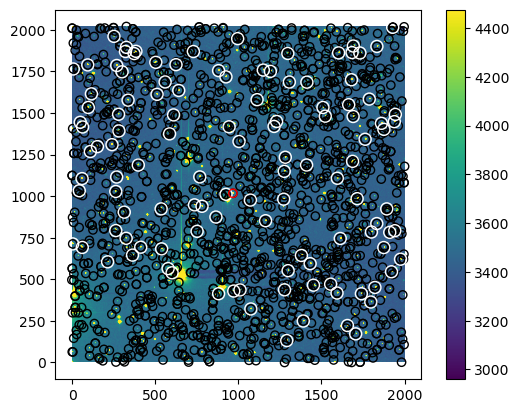

In [55]:
# plot the sources on the frames
# plot the first fits file that we have downloaded

for fi in df_phot["file"]:
    if os.path.isfile(fi):
        f = fi
        break
    else:
        f = None
        
if f:
        
    print(f)
    hdu = fits.open(f)
    img = hdu[0].data
    hdr = hdu[0].header
    wcs = WCS(hdr)

    fig = plt.figure()
    gs = gridspec.GridSpec(1, 1)
    ax1 = plt.subplot(gs[0,0])

    plot_img = img

    # plot the image
    norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
    s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
    c1 = plt.colorbar(s1)

    # plot all detected sources in pixel coords
    df_plot = df_phot_cal[df_phot_cal["file"]==f]
    ax1.scatter(df_plot["x_fit"],df_plot["y_fit"],edgecolor='k',facecolor="none")
    
    # plot sources matched with the catalogue
    df_plot2 = df_plot[df_plot["objid"]!=999999]
    ax1.scatter(df_plot2["x_fit"],df_plot2["y_fit"],edgecolor='w',facecolor="none", s = 75)

    # plot the target in pixel coords
    df_plot3 = df_plot[df_plot["target_name"]==target_name]
    ax1.scatter(df_plot3["x_fit"],df_plot3["y_fit"],edgecolor='r',facecolor="none")

#     # plot the target in ra, dec
#     df_plot4 = df_fits[df_fits["file"]==f]
#     c = SkyCoord(df_plot4["ra_eph"],df_plot4["dec_eph"], unit=(u.deg, u.deg))
#     x,y = c.to_pixel(wcs)
#     ax1.scatter(x,y,edgecolor = "w", facecolor = "none", s=100)
    
    plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

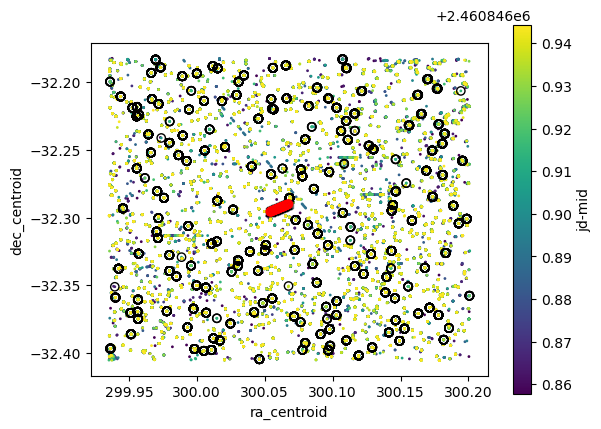

In [56]:
# plot all detections in observing block

x_plot = "ra_centroid"
y_plot = "dec_centroid"
c_plot = "jd-mid"
df_plot = df_phot_cal.sort_values(c_plot) # all detections
df_plot2 = df_plot[df_plot["target_name"]==target_name] # detections matched with target
df_plot3 = df_plot[df_plot["objid"]!=999999] # detections matched with catalogue

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

# plot all detections
s1 = ax1.scatter(df_plot[x_plot],df_plot[y_plot],c=df_plot[c_plot],s=1)
cbar = plt.colorbar(s1)

# highlight the catalogue matches
ax1.scatter(df_plot3[x_plot],df_plot3[y_plot],edgecolor = "k", facecolor = "none")

# Plot target eph
ax1.scatter(df_fits["ra_eph"],df_fits["dec_eph"],edgecolor = "k", facecolor = "none", marker = "s", alpha = 0.5)
# ax1.scatter(df_fits["ra_eph"],df_fits["dec_eph"],c = df_fits[c_plot], marker = "s")

# highlight detections matched with target target
ax1.scatter(df_plot2[x_plot],df_plot2[y_plot],edgecolor = "r", facecolor = "none")

# mark rejected target detections (too far from predicted position)
mask_target = df_plot2["target_sep"]<target_sep_cut
ax1.scatter(df_plot2[~mask_target][x_plot],df_plot2[~mask_target][y_plot],marker = "x",c = "r", facecolor = "none")

ax1.set_aspect("equal")
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
cbar.set_label(c_plot)

plt.show

initial matches = 39
matches after sep cut = 39


<function matplotlib.pyplot.show(close=None, block=None)>

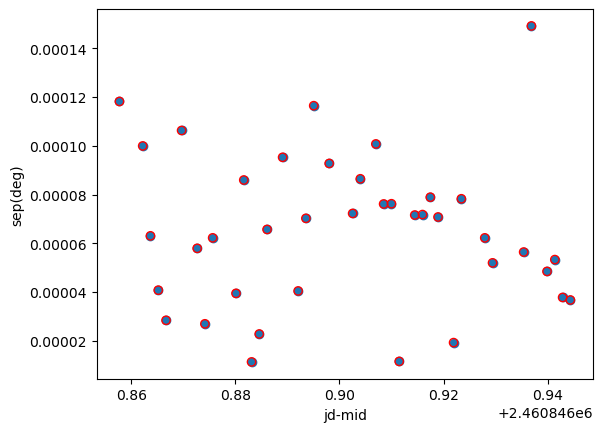

In [57]:
# Inspect the separation of detections matched with target to predicted ephemerides
x_plot = "jd-mid"
y_plot = "target_sep"
df_plot = df_phot_cal[df_phot_cal["target_name"]==target_name]
print("initial matches = {}".format(len(df_plot)))

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

s1 = ax1.scatter(df_plot[x_plot],df_plot[y_plot])

mask_target = df_plot[y_plot]<target_sep_cut
print("matches after sep cut = {}".format(len(mask_target)))
ax1.scatter(df_plot[mask_target][x_plot],df_plot[mask_target][y_plot],edgecolor = "r", facecolor = "none")

ax1.set_ylabel("sep(deg)")
ax1.set_xlabel(x_plot)

plt.show

In [58]:
len(df_fits)

39

In [59]:
# Drop frames were the target could not be matched
keep_times = df_phot_cal[df_phot_cal["target_name"]==target_name]["jd-mid"]
df_phot_cal = df_phot_cal[np.isin(df_phot_cal["jd-mid"],keep_times)].reset_index(drop=True)
df_fits = df_fits[np.isin(df_fits["jd-mid"],keep_times)].reset_index(drop=True)

In [60]:
len(df_fits)

39

In [61]:
# each catalogue star should appear in len(df_fits) number of frames
df_phot_cal.value_counts("objid")

objid
999999               42677
69282999559553715       39
69253000682287494       39
69253001443731316       39
69262999709563560       39
                     ...  
69312999739360538        1
69353001943442374        1
69172999398299084        1
69173000675659482        1
69202999887785139        1
Name: count, Length: 190, dtype: int64

In [62]:
# select catalogues stars appearing in all frames
df_cal = df_phot_cal[(df_phot_cal["objid"]!=999999) & (pd.isnull(df_phot_cal["target_name"]))]
cal_stars_id = df_cal.value_counts("objid").index[df_cal.value_counts("objid").values==len(df_fits)].to_list()
# cal_stars_id = df_cal.value_counts("objid").index[df_cal.value_counts("objid").values>=(0.9 * len(df_fits))].to_list()
cal_stars_id = np.array(cal_stars_id)
len("number of stars for calibration = {}".format(cal_stars_id))

2005

In [63]:
len(phot_files)

75

In [64]:
# check number of times each star appears in dataframe
df_cal[np.isin(df_cal["objid"],cal_stars_id)].value_counts("objid")

objid
69113001191738175    39
69292999866245336    39
69323000453297524    39
69322999558569624    39
69312999897142698    39
                     ..
69192999798733041    39
69183001396977706    39
69182999997630208    39
69173001388743954    39
69373001101322210    39
Name: count, Length: 108, dtype: int64

In [65]:
# check number of times target appears in dataframe
len(df_phot_cal[df_phot_cal["target_name"]==target_name])

39

In [66]:
# # TODO: add nan measurements for cal_stars at missing times
# for t in np.unique(df_phot_cal["jd-mid"]):
#     _df = df_phot_cal[df_phot_cal["jd-mid"] == t]
#     print(t,len(_df))
    
#     missing = cal_stars_id[~np.isin(cal_stars_id,_df["objid"])]
#     print(missing)
    
#     if len(missing)>0:
#         data = {"objid":missing,
#                 "m_inst":[np.nan]*len(missing),
#                "jd-mid":[t]*len(missing)}
#         df_missing = pd.DataFrame(data)
#         df_phot_cal = pd.concat([df_phot_cal,df_missing], axis = 0)
        
# # TODO: whay do we get multiple rows for some objects?
# # df_phot_cal = df_phot_cal[np.isin(df_phot_cal["objid"],cal_stars_id)].drop_duplicates(subset=["jd-mid","objid","m_inst"])
# df_phot_cal = df_phot_cal.drop_duplicates(subset=["jd-mid","objid","target_name"]).reset_index(drop=True)

48593
save uncal_lightcurve_Verstappen_20250619.png


<function matplotlib.pyplot.show(close=None, block=None)>

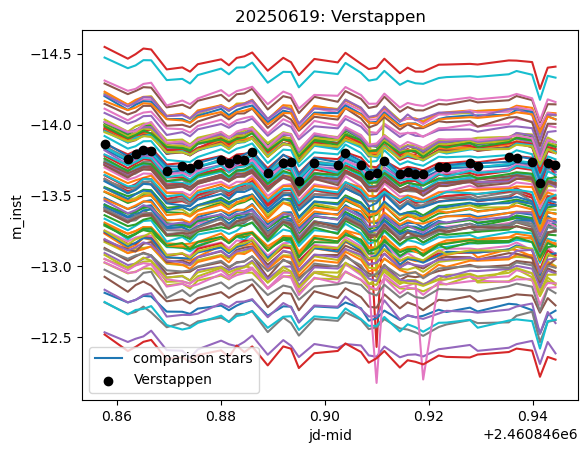

In [67]:
# plot the "raw" uncalibrated lightcurve of target and catalogue stars
x_plot = "jd-mid"
y_plot = "m_inst"

df_plot = df_phot_cal.sort_values("jd-mid")
print(len(df_plot))

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

# comparison star lightcurves
# these should be flat but will change with observing conditions
ax1.plot([],[],label = "comparison stars")
for objid in cal_stars_id:
    _df_plot = df_plot[df_plot["objid"]==objid]
    ax1.plot(_df_plot[x_plot],_df_plot[y_plot])

# plot target lightcurve
_df_plot = df_plot[df_plot["target_name"]==target_name]
mask_target = _df_plot["target_sep"]<target_sep_cut
_df_plot = _df_plot[mask_target] # exclude high separation matches
ax1.scatter(_df_plot[x_plot],_df_plot[y_plot], c= "k",zorder=3, label = target_name)

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.invert_yaxis()
ax1.legend()

plt.title("{}: {}".format(night, target_name))

# # limit axes for plotting?
# mag_med = np.nanmedian(_df_plot[y_plot])
# mag_std = np.nanstd(_df_plot[y_plot])
# sigma = 2
# ax1.set_ylim(mag_med + sigma*mag_std, mag_med - sigma*mag_std)

fname = "uncal_lightcurve_{}_{}.png".format(target_name_save,night)
print("save {}".format(fname))
plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")

plt.show

C = -0.08445178090495507 +/- 0.03080747328204546


<function matplotlib.pyplot.show(close=None, block=None)>

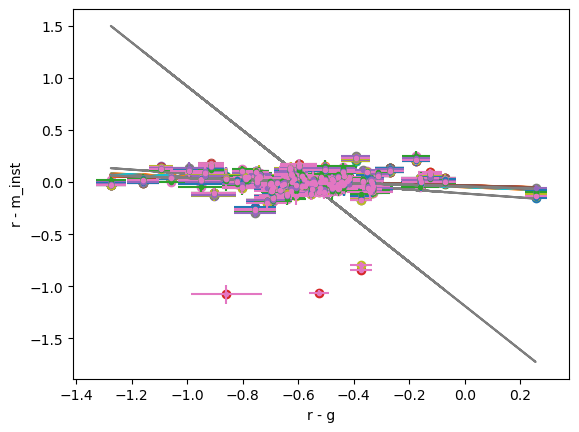

In [68]:
# work out instrument colour term for calibration
# TODO: should really use the best frame for this shift (i.e. a reference frame)
# TODO: should calculate this using data from across the observing semester

df_plot = df_phot_cal[np.isin(df_phot_cal["objid"],cal_stars_id)]

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

times = np.array(df_phot_cal[df_phot_cal["target_name"]==target_name]["jd-mid"])
popt_all = []
C_list = []
C_err_list = []

for t in times:
    _df_plot = df_plot[df_plot["jd-mid"]==t]
    
    # plot the magnitude and colour axes with errorbars
    x = _df_plot[mag_obs]-_df_plot[mag_ref]
    x_err = np.sqrt(_df_plot[mag_obs_err]**2.0 + _df_plot[mag_ref_err]**2.0)
    y = _df_plot[mag_obs] - _df_plot["m_inst"]
    y_err = np.sqrt(_df_plot[mag_obs_err]**2.0 + _df_plot["m_inst_err"]**2.0)
    y = y - np.nanmedian(y)
    ax1.scatter(x,y)
    ax1.errorbar(x,y,xerr=x_err,yerr=y_err,fmt=".")
    
    # apply orthogonal distance regression to get a colour term (gradient) and initial zp (y intercept)
    data = odr.RealData(x, y, sx = x_err, sy = y_err)
    odr1 = odr.ODR(data, odr.unilinear)
    out = odr1.run()
    C = out.beta[0]
    zp_initial = out.beta[1]
    C_err = out.sd_beta[0]
    ax1.plot(x, linear_func(x,C,zp_initial))
    C_list.append(C)
    C_err_list.append(C_err)
        
# get the overall colour term (and uncertainty) from median of all frames
C = np.nanmedian(C_list)
C_err = np.nanmedian(C_err_list)
print("C = {} +/- {}".format(C,C_err))
    
ax1.set_xlabel("{} - {}".format(mag_obs,mag_ref))
ax1.set_ylabel("{} - m_inst".format(mag_obs))

plt.show

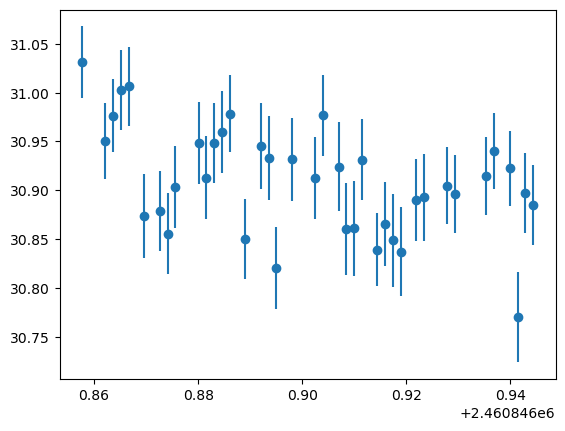

In [69]:
# Plot the zeropoint for each frame

times = np.array(df_phot_cal[df_phot_cal["target_name"]==target_name]["jd-mid"])
zp_frame = []
zp_frame_err = []

for t in times:
    
    df = df_phot_cal[(np.isin(df_phot_cal["objid"],cal_stars_id)) & (df_phot_cal["jd-mid"]==t)]
    
    zp = df[mag_obs] - df["m_inst"] - (C*(df[mag_obs]-df[mag_ref]))
    
    zp_frame.append(np.nanmedian(zp))
    zp_frame_err.append(median_abs_deviation(zp, nan_policy = "omit"))

zp_frame = np.array(zp_frame)
    
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

ax1.scatter(times,zp_frame)
ax1.errorbar(times,zp_frame,zp_frame_err,fmt=".")

plt.show()

# calculate differential photometry

In [70]:
# Use some assumed colour and uncertainty of the target
# TODO: update this with better knowledge when available
color = 0.2
sigma_color = 0.02

In [71]:
# get brightest star from first frame
_df_phot = df_phot_cal[(df_phot_cal["jd-mid"]==np.amin(df_phot_cal["jd-mid"])) & (np.isin(df_phot_cal["objid"],cal_stars_id))]
i_bright = np.argmin(_df_phot["m_inst"])
objid_bright = np.array(_df_phot["objid"])[i_bright]
print(objid_bright)

69363000001067569


In [72]:
# instrumental mag of target as a function of time
frame_mag_t = np.array(df_phot_cal[df_phot_cal["target_name"]==target_name]["m_inst"])

# find the target minus comparison inst mag difference for each star
# NB the shapes of each np array
delta_t_c_i = []
for objid in cal_stars_id:
    # TODO: sometimes the target is matched with a cal star?
    frame_mag_c = np.array(df_phot_cal[(df_phot_cal["target_name"]!=target_name) & (df_phot_cal["objid"]==objid)]["m_inst"])
    delta_t_c_i.append(frame_mag_t - frame_mag_c)
    
delta_t_c_i = np.array(delta_t_c_i)
delta_t_c_i.shape

(108, 39)

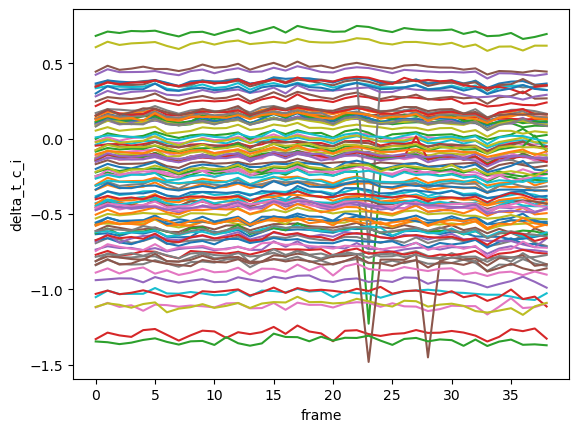

In [73]:
# plot the inst mag difference for each star
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

for i,objid in enumerate(cal_stars_id):
    
    x = delta_t_c_i[i,:]
    ax1.plot(np.arange(len(x)),x)
    
ax1.set_xlabel("frame")
ax1.set_ylabel("delta_t_c_i")

plt.show()

In [74]:
# Get the inst mag lightcurve of the brightest star
frame_c_bright = np.array(df_phot_cal[df_phot_cal["objid"]==objid_bright]["m_inst"])

# find the catalogue minus bright star inst mag difference for each star
delta_c_bright_i = []
for objid in cal_stars_id:
    frame_mag_c = np.array(df_phot_cal[(df_phot_cal["target_name"]!=target_name) & (df_phot_cal["objid"]==objid)]["m_inst"])
    delta_c_bright_i.append(frame_mag_c - frame_c_bright)
    
delta_c_bright_i = np.array(delta_c_bright_i)
delta_c_bright_i.shape

(108, 39)

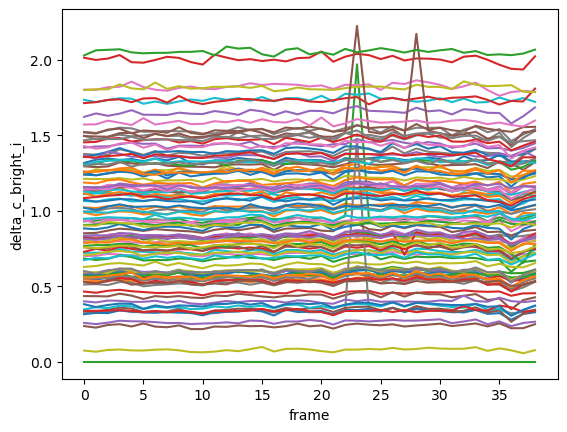

In [75]:
# plot the bright star inst mag difference for each star
# NB the line at zero is the bright star
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

_x = np.nanmean(delta_c_bright_i,axis=1)

for i,objid in enumerate(cal_stars_id):
    
    x = delta_c_bright_i[i,:]
    ax1.plot(np.arange(len(x)),x)
        
ax1.set_xlabel("frame")
ax1.set_ylabel("delta_c_bright_i")

plt.show()

In [76]:
# get the magnitude difference lightcurve for the target, for each star
# for each comparison star, add the mean comp - bright magnitude
# this has to be the mean comp - bright across all frames, otherwise the delta mag collapses to target - bright
# taking the mean drives down uncertainty on the comp - bright magnitude
delta_mag = []
for i in range(len(delta_t_c_i)):
    delta_mag.append(delta_t_c_i[i] + np.nanmean(delta_c_bright_i,axis=1)[i])
    
delta_mag = np.array(delta_mag)
delta_mag.shape

(108, 39)

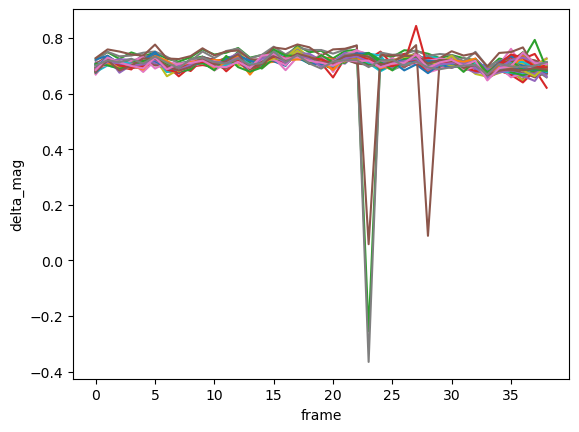

In [77]:
# plot target diff mag lightcurve for each star
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

for i,objid in enumerate(cal_stars_id):
    
    x = delta_mag[i,:]
    ax1.plot(np.arange(len(x)),x)
    
ax1.set_xlabel("frame")
ax1.set_ylabel("delta_mag")

plt.show()

In [78]:
# take the median of all diff magnitudes to get a single diff mag lightcurve for the target
dm = np.nanmedian(delta_mag,axis = 0)
sigma_dm = median_abs_deviation(delta_mag, axis = 0, nan_policy = "omit") # uncertainty from differential photometry

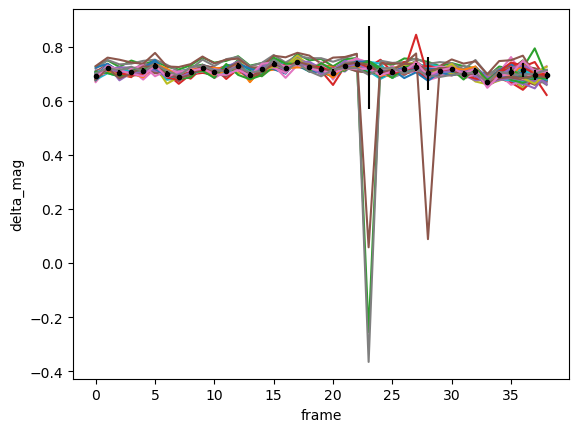

In [79]:
# plot the target median diff mag lightcurve compared to all diff mag lightcurves
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

for i,objid in enumerate(cal_stars_id):
    
    x = delta_mag[i,:]
    ax1.plot(np.arange(len(x)),x)
    
ax1.errorbar(np.arange(len(x)),dm,np.std(delta_mag, axis = 0),fmt = "k.")
    
ax1.set_xlabel("frame")
ax1.set_ylabel("delta_mag")

plt.show()

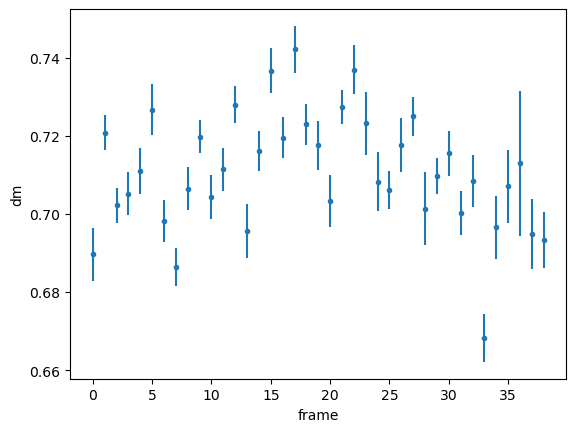

In [80]:
# plot the final target diff mag lightcurve
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

ax1.errorbar(np.arange(len(dm)),dm,sigma_dm,fmt = ".")
    
ax1.set_xlabel("frame")
ax1.set_ylabel("dm")

plt.show()

In [81]:
# Calculate the calibrated mag of brightest star
# TODO: change variable names to be agnostic of calibration catalogue
df_bright = df_phot_cal[df_phot_cal['objid']==objid_bright]
m_inst_bright = df_bright["m_inst"]
m_inst_bright_err = df_bright["m_inst_err"]
rmi_bright = df_bright[mag_obs] - df_bright[mag_ref]
r_ps1_bright = df_bright[mag_obs]

m_bright = (C*rmi_bright) + zp_frame + m_inst_bright
np.nanmedian(m_bright - r_ps1_bright)

0.12114571929827633

In [82]:
# find the calibration shift of dm for each night to get a catalogue calibrated lightcurve
# then shift by the calibrated bright star magnitude
df_target = df_phot_cal[(df_phot_cal["target_name"]==target_name)]
m_inst = np.array(df_target["m_inst"])

mag_target = (C * color) + zp_frame + dm + m_inst_bright # TODO: the bright comp star colour cancels?

mag_target

583      17.156274
2230     17.189486
3694     17.165266
5206     17.154825
6748     17.170767
8119     17.194458
9263     17.156443
10410    17.151955
11604    17.166961
12956    17.191413
14329    17.181866
15677    17.172997
17115    17.189275
18550    17.149031
19931    17.169303
21137    17.194456
22453    17.195934
23718    17.197123
24888    17.174989
26216    17.174706
27530    17.157151
28847    17.206026
30051    17.188860
30982    17.165895
32005    17.157943
33074    17.165792
34045    17.164405
35165    17.183014
36278    17.148311
37432    17.160717
38647    17.167808
39844    17.159596
41108    17.164019
42312    17.113717
43508    17.168448
44788    17.171940
45965    17.214624
47061    17.173773
48012    17.152433
Name: m_inst, dtype: float64

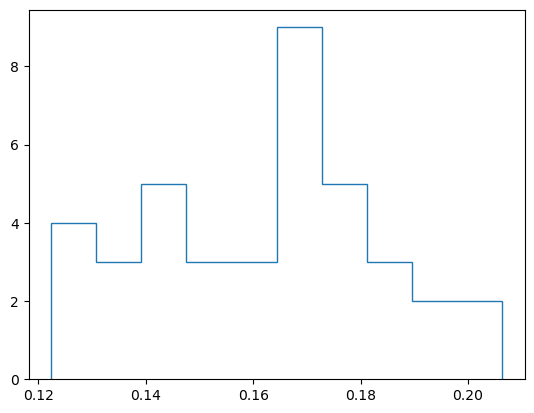

In [83]:
mag_target = (C * color) + zp_frame + dm + m_inst_bright # the bright comp star colour cancels?

    
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

for i in range(len(delta_t_c_i)):

    ax1.hist(delta_t_c_i[i], histtype = "step")
    break

plt.show()


In [84]:
# Propagate uncertainties
# TODO: check this, are we overestimating uncertainties?

# error in the (assumed?) target colour
sigma_rmi_t = sigma_color 

# error in determination of the instrument colour term
sigma_C = C_err

# error in the zeropoint
sigma_zp = np.array(zp_frame_err)
# sigma_zp = np.array(zp_frame_err)/2.0

# uncertainty introduced by taking the median of the delta_mag
sigma_mad = sigma_dm

# comparison star instrumental uncertainty
sigma_m_i = []

# colour error for the comparison star (PS1 catalogue)
sigma_rmi_c = []

# catalogue magnitude uncertainty of comp star (PS1 catalogue)
sigma_m_c = []


for objid in cal_stars_id:
    df_c = df_phot_cal[(df_phot_cal["target_name"]!=target_name) & (df_phot_cal["objid"]==objid)]
    
    m_c_inst_err = np.array(df_c["m_inst_err"])
    m_c_r_err = np.array(df_c[mag_obs_err])
    m_c_i_err = np.array(df_c[mag_ref_err])
    
    sigma_rmi_c.append(np.sqrt(np.array(m_c_r_err)**2.0 + np.array(m_c_i_err)**2.0))
    sigma_m_i.append(m_c_inst_err)
    sigma_m_c.append(m_c_r_err)
    
sigma_rmi_c = np.array(sigma_rmi_c)
sigma_m_i = np.array(sigma_m_i)
sigma_m_c = np.array(sigma_m_c)
    

# target instrumental mag uncertainty
sigma_m_inst_t = np.array(df_phot_cal[df_phot_cal["target_name"]==target_name]["m_inst_err"])

# uncertainty of the target - comp star mag
sigma_delta_m_t_i = np.sqrt(sigma_m_inst_t**2.0 + sigma_m_i**2.0) # should be 2d
sigma_delta_m_t_i = np.nanmedian(sigma_delta_m_t_i,axis=0) # make len of number of frames

# bright star instrumental uncertainty
sigma_bright_i = np.array(m_inst_bright_err)

# uncertainty of the comp star - bright star mag diff
sigma_delta_bright_i = np.sqrt(sigma_m_i**2.0 + sigma_bright_i**2.0)
sigma_delta_bright_i = np.nanmedian(sigma_delta_bright_i,axis=0) # take the median to get 1d array for all times

# take the mean across all frames
sigma_delta_bright_i_mean = (1.0/len(df_fits)) * np.sqrt(np.nansum(sigma_delta_bright_i**2.0))

# error on diff mag including taking the median
sigma_delta_m = np.sqrt(sigma_delta_m_t_i**2.0 + sigma_delta_bright_i_mean**2.0 + sigma_mad**2.0)

# calibration uncertainty
# mag_target = (C * color) + zp_frame + dm + m_inst_bright # the bright comp star colour cancels?
sigma_m_t = np.sqrt(sigma_C**2.0 + 
                   sigma_rmi_t**2.0 + 
                   sigma_zp**2.0 + 
                   sigma_bright_i**2.0 + 
                   sigma_delta_m**2.0)

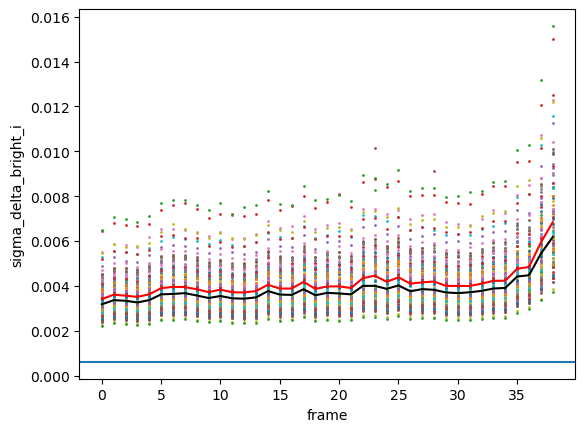

In [85]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

x = np.sqrt(sigma_m_i**2.0 + sigma_bright_i**2.0)

for i,objid in enumerate(cal_stars_id):
    
    _x = x[i,:]
    ax1.scatter(np.arange(len(_x)),_x, s = 1)
    
ax1.plot(np.arange(len(x[0,:])),np.nanmedian(x,axis=0), c = "k")
ax1.plot(np.arange(len(x[0,:])),np.nanmean(x,axis=0), c = "r")

ax1.axhline(sigma_delta_bright_i_mean)
    
ax1.set_xlabel("frame")
ax1.set_ylabel("sigma_delta_bright_i")

plt.show()

In [86]:
# Median error contribution from: instrument colour, target colour, zeropoint,bright star instrumental, diff mag (including taking the mean)
for x in [sigma_C,sigma_rmi_t,sigma_zp,sigma_bright_i,sigma_delta_m,
          np.sqrt(sigma_delta_m_t_i**2.0 + sigma_delta_bright_i_mean**2.0),sigma_mad]:
    print(np.nanmedian(x))

0.03080747328204546
0.02
0.04164871672346848
0.0017610983776467015
0.007156421072655702
0.004347277021358447
0.005766199056726706


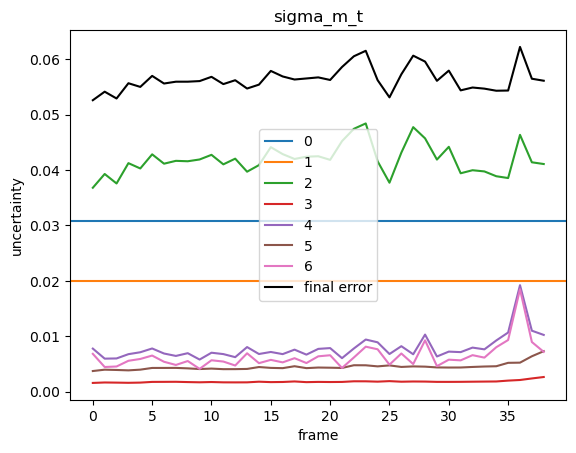

In [87]:
# plot error contribution for each term as a function of time
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

for i,x in enumerate([sigma_C,sigma_rmi_t,sigma_zp,sigma_bright_i,sigma_delta_m,
          np.sqrt(sigma_delta_m_t_i**2.0 + sigma_delta_bright_i_mean**2.0),sigma_mad]):
    
    if isinstance(x, np.ndarray):
        ax1.plot(np.arange(len(x)),x, c = "C{}".format(i), label = i)
    else:
        ax1.axhline(x, c = "C{}".format(i), label = i)
        
ax1.plot(np.arange(len(sigma_m_t)),sigma_m_t, c = "k", label = "final error")

ax1.legend()

plt.title("sigma_m_t")

ax1.set_xlabel("frame")
ax1.set_ylabel("uncertainty")
        
plt.show()

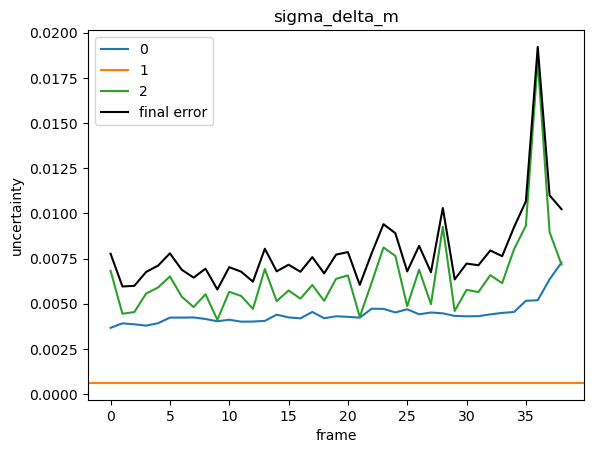

In [88]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

for i,x in enumerate([sigma_delta_m_t_i, sigma_delta_bright_i_mean, sigma_mad]):
    
    if isinstance(x, np.ndarray):
        ax1.plot(np.arange(len(x)),x, c = "C{}".format(i), label = i)
    else:
        ax1.axhline(x, c = "C{}".format(i), label = i)
        
ax1.plot(np.arange(len(sigma_delta_m)),sigma_delta_m, c = "k", label = "final error")

ax1.legend()

plt.title("sigma_delta_m")

ax1.set_xlabel("frame")
ax1.set_ylabel("uncertainty")
        
plt.show()

save cal_lightcurve_Verstappen_20250619.png


<function matplotlib.pyplot.show(close=None, block=None)>

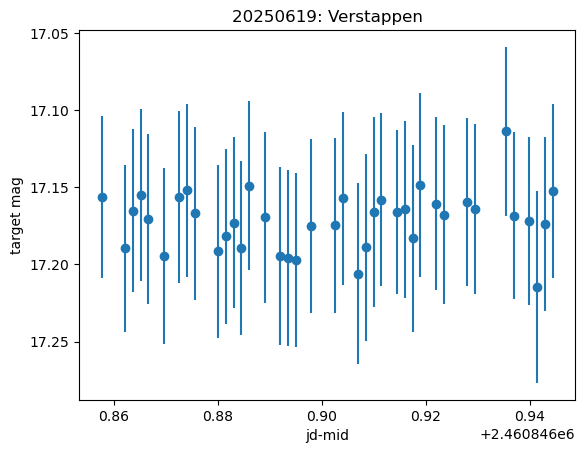

In [89]:
# plot the final calibrated magnitude lightcurve of target, with propagated uncertainties
x_plot = "jd-mid"

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

t = np.array(df_phot_cal[df_phot_cal["target_name"]==target_name][x_plot])

# ax1.scatter(t,mag_target)
# ax1.errorbar(t,mag_target, sigma_m_t,fmt = ".")

# trim large outliers
mag_med = np.nanmedian(mag_target)
mag_std = np.std(mag_target)
m_diff = np.abs(mag_target - mag_med)
m_cut = 2
mask_mag = m_diff < m_cut
# mask_sigma = ~np.isnan(sigma_m_t)
# mask_mag = mask_mag & mask_sigma

ax1.scatter(t[mask_mag],mag_target[mask_mag])
ax1.errorbar(t[mask_mag],mag_target[mask_mag], sigma_m_t[mask_mag],fmt = ".")

# t = np.array(t)
# m = np.array(mag_target)
# _m = np.array(mag_target[mask])
# for i in range(len(t)):
#     if (m[i] > 16.0) & (m[i] in _m):
#         ax1.text(t[i],m[i],df_fits.iloc[i]["irafname"])

ax1.set_xlabel(x_plot)
ax1.set_ylabel("target mag")


# sigma = 1
# ax1.set_ylim(mag_med + sigma*mag_std, mag_med - sigma*mag_std)

ax1.invert_yaxis()
# ax1.legend()

plt.title("{}: {}".format(night,target_name))

fname = "cal_lightcurve_{}_{}.png".format(target_name_save,night)
print("save {}".format(fname))
plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")

plt.show

In [91]:
# save the calibrated target magnitude, alongside required ephemeris values for phase curve correction
df_phot_cal["m"] = np.nan
df_phot_cal["m_err"] = np.nan
mask = df_phot_cal["target_name"]==target_name
df_phot_cal.loc[mask,"m"] = np.array(mag_target)
df_phot_cal.loc[mask,"m_err"] = np.array(sigma_m_t)

df_save = df_phot_cal.copy()[mask]
df_save = df_save.merge(df_fits[["file","alpha(deg)","r(AU)","delta(AU)"]], on = "file")
df_save = df_save[["target_name","file","jd-mid","m","m_err","alpha(deg)","r(AU)","delta(AU)"]].reset_index(drop = True)

fname_mag = "df_cal_mag_{}_{}.csv".format(night,target_name_save)
print("save {}".format(fname_mag))
df_save.to_csv(fname_mag)

save df_cal_mag_20250619_Verstappen.csv


In [92]:
df_save

,target_name,file,jd-mid,m,m_err,alpha(deg),r(AU),delta(AU)
0,Verstappen,/Users/jrobinson/telescope_data/DT_2025/Scienc...,2.460847e+06,17.156274,0.052589,13.403957,2.118280,1.170831
1,Verstappen,/Users/jrobinson/telescope_data/DT_2025/Scienc...,2.460847e+06,17.189486,0.054129,13.402027,2.118277,1.170807
2,Verstappen,/Users/jrobinson/telescope_data/DT_2025/Scienc...,2.460847e+06,17.165266,0.052902,13.401383,2.118276,1.170799
3,Verstappen,/Users/jrobinson/telescope_data/DT_2025/Scienc...,2.460847e+06,17.154825,0.055654,13.400733,2.118275,1.170791
4,Verstappen,/Users/jrobinson/telescope_data/DT_2025/Scienc...,2.460847e+06,17.170767,0.054993,13.400087,2.118274,1.170783
5,Verstappen,/Users/jrobinson/telescope_data/DT_2025/Scienc...,2.460847e+06,17.194458,0.056979,13.398797,2.118273,1.170767
6,Verstappen,/Users/jrobinson/telescope_data/DT_2025/Scienc...,2.460847e+06,17.156443,0.055602,13.397502,2.118271,1.170751
7,Verstappen,/Users/jrobinson/telescope_data/DT_2025/Scienc...,2.460847e+06,17.151955,0.055932,13.396862,2.118270,1.170743
8,Verstappen,/Users/jrobinson/telescope_data/DT_2025/Scienc...,2.460847e+06,17.166961,0.055933,13.396256,2.118269,1.170735
9,Verstappen,/Users/jrobinson/telescope_data/DT_2025/Scienc...,2.460847e+06,17.191413,0.056042,13.394378,2.118266,1.170711
